# Lithology Masks

This notebook generates the required lithology input files to GEOCLIM from GLiM + LiMW.

In [1]:
import datetime
import pandas as pd
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from matplotlib import cm
from tqdm import tqdm_notebook

## Functions

In [2]:
def plot_z(z, lat, lon, zlabel, coastlines=False, output=False, **kwargs):
    """
    Plot data.

    Parameters
    ----------
    z : array
        the data (unsnaked)
        
    lat : array
        of latitude
        
    lon : array
        of longitude
        
    zlabel : string
        label for the colorbar
        
    coastlines : boolean
        set whether coastlines will be drawn (default False)
        
    output : boolean
        if true, return the figure and axis handles (default False)
        
    **kwargs
        passed to plt.pcolormesh()
    """
    #wrap the longitude vector around an arbitary point in order to fix non-plotting issue on date line
    wrapped_lon = np.concatenate([lon[5:],lon[:5]])
    wrapped_z = np.concatenate([z[:,5:],z[:,:5]],1)

    fig = plt.figure(figsize=(15,6))

    ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
    if coastlines:
        ax.coastlines()
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 color='gray', alpha=0.5, linestyle='--')

    im = ax.pcolormesh(wrapped_lon, lat, wrapped_z, transform=ccrs.PlateCarree(), **kwargs)
    im = ax.pcolormesh(lon, lat, z, transform=ccrs.PlateCarree(), **kwargs)
    
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel(zlabel, rotation=270, labelpad=20)

    if output!=False:
        return fig, ax

In [3]:
def snake_it(array, filename=None):
    """
    Convert a netcdf variable into a single column vector, and save to text file.

    Parameters
    ----------
    array : netcdf variable, or array
        Must be 2d. Ensure that the array is (lat,lon).
        
    filename : string
        if set, the snake will be saved with filename.

    Returns
    -------
    snaked : single column array
    """
    dim = np.shape(array)
    if len(dim)!=2:
        print('The array does not have 2 dimensions! Nothing returned.')
    else:
        snaked = np.array([])
        for i in range(dim[0]):
            for j in range(dim[1]):
                snaked = np.append(snaked, array[i,j])
        if filename != None:
            np.savetxt(filename, snaked, newline='\n')
        return snaked

In [4]:
def plot_snake(snake, lat, lon, zlabel):
    """
    Plot snaked data (by unsnaking it first).

    Parameters
    ----------
    snake : array
        the data (snaked)
        
    lat : array
        of latitude
        
    lon : array
        of longitude
        
    zlabel : string
        label for the colorbar
    """
    dim = (len(lat), len(lon))
    unsnaked = np.ones(shape=dim)
    for i in range(dim[0]):
        for j in range(dim[1]):
            unsnaked[i,j] = snake[dim[1]*i+j]

    plot_z(unsnaked, lat, lon, zlabel)

In [5]:
def plot_lithology(lith_mask, lat, lon, projection=ccrs.PlateCarree(), coastlines=False, output=False):
    """
    Plot lithology data.

    Parameters
    ----------
    lith_mask : array
        the lithological mask (unsnaked)
        
    lat : array
        of latitude
        
    lon : array
        of longitude
        
    projection : cartopy projection
        as ccrs.XXX()
      
    coastlines : boolean
        set whether coastlines will be drawn (default False)
        
    output : boolean
        if true, return the figure and axis handles (default False)
    """
    z = lith_mask
    
    # wrap the longitude vector around an arbitary point in order to fix non-plotting issue on date line
    wrapped_lon = np.concatenate([lon[5:],lon[:5]])
    wrapped_z = np.concatenate([z[:,5:],z[:,:5]],1)

    # set up the figure
    fig = plt.figure(figsize=(15,6))
    ax = plt.subplot(1,1,1, projection=projection)
    if coastlines:
        ax.coastlines()
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 color='gray', alpha=0.5, linestyle='--')
    
    # set up the discrete colormap
    cmap = colors.ListedColormap(['gainsboro',
                                  'mediumseagreen',
                                  'pink',
                                  'darkorange',
                                  'orangered',
                                  'dodgerblue',
                                  'C7'])
    bounds = np.arange(-0.5,7.5,1)
    norm = colors.BoundaryNorm(bounds, cmap.N)

    # plot the data
    im = ax.pcolormesh(wrapped_lon, lat, wrapped_z, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
    im = ax.pcolormesh(lon, lat, z, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
    
    # add the colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_ticks(np.arange(7))
    cbar.set_ticklabels(['0 = water/ice',
                         '1 = metamorphics',
                         '2 = felsics',
                         '3 = intermediates',
                         '4 = mafics',
                         '5 = carbonates',
                         '6 = sediments'])

    if output!=False:
        return fig, ax

In [6]:
def plot_CaMg(lith_mask, lat, lon, projection=ccrs.PlateCarree(), coastlines=False, output=False, **kwargs):
    """
    Plot Ca+Mg.

    Parameters
    ----------
    lith_mask : array
        the lithological mask (unsnaked)
        
    lat : array
        of latitude
        
    lon : array
        of longitude
        
    projection : cartopy projection
        as ccrs.XXX()
      
    coastlines : boolean
        set whether coastlines will be drawn (default False)
        
    output : boolean
        if true, return the figure and axis handles (default False)
        
    **kwargs
        passed to plt.pcolormesh()
    """
    CaMg_vals = np.array([0, 3390, 1521, 4759, 10317, 0, 2235])
    
    z = np.zeros((len(lat), len(lon)))
    
    for i in range(len(CaMg_vals)):
        z = z + lith_mask[:,:,i] * CaMg_vals[i]
    
    #wrap the longitude vector around an arbitary point in order to fix non-plotting issue on date line
    wrapped_lon = np.concatenate([lon[5:],lon[:5]])
    wrapped_z = np.concatenate([z[:,5:],z[:,:5]],1)

    fig = plt.figure(figsize=(15,6))

    ax = plt.subplot(1,1,1, projection=projection)
    if coastlines:
        ax.coastlines()
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 color='gray', alpha=0.5, linestyle='--')

    im = ax.pcolormesh(wrapped_lon, lat, wrapped_z, transform=ccrs.PlateCarree(), **kwargs)
    im = ax.pcolormesh(lon, lat, z, transform=ccrs.PlateCarree(), **kwargs)
    
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('PRELIMINARY\nmean Ca+Mg [mol/m$^{3}$]', rotation=270, labelpad=20)

    if output!=False:
        return fig, ax

## LiMW

This file was rasterized in QGIS at 3600x1800 resolution (0.1x0.1 degree) from the raw LiMW shapefile:

In [7]:
LiMW = Dataset('../Input/LiMW_3600_1800.nc')
dim_raw = np.shape(LiMW.variables['Band1'][:,:])
print(dim_raw)

(1800, 3600)


| ID | code | description                     | classification |
|----|------|---------------------------------|----------------|
| 1  | su   | unconsolidated sediments        | 6              |
| 2  | vb   | basic volcanic rocks            | 4              |
| 3  | ss   | siliciclastic sedimentary rocks | 6              |
| 4  | pb   | basic plutonic rocks            | 4              |
| 5  | sm   | mixed sedimentary rocks         | 6              |
| 6  | sc   | carbonate sedimentary rocks     | 5              |
| 7  | va   | acid volcanic rocks             | 2              |
| 8  | mt   | metamorphics                    | 1              |
| 9  | pa   | acid plutonic rocks             | 2              |
| 10 | vi   | intermediate volcanic rocks     | 3              |
| 11 | wb   | water bodies                    | 0              |
| 12 | py   | pyroclastics                    | 2              |
| 13 | pi   | intermediate plutonic rocks     | 3              |
| 14 | ev   | evaporites                      | 5              |
| 15 | nd   | no data                         | 1              |
| 16 | ig   | ice and glaciers                | 0              |

Our classification code:

* 0 = ocean/water/ice
* 1 = metamorphics
* 2 = felsics
* 3 = intermediates
* 4 = mafics
* 5 = carbonates
* 6 = siliciclastics

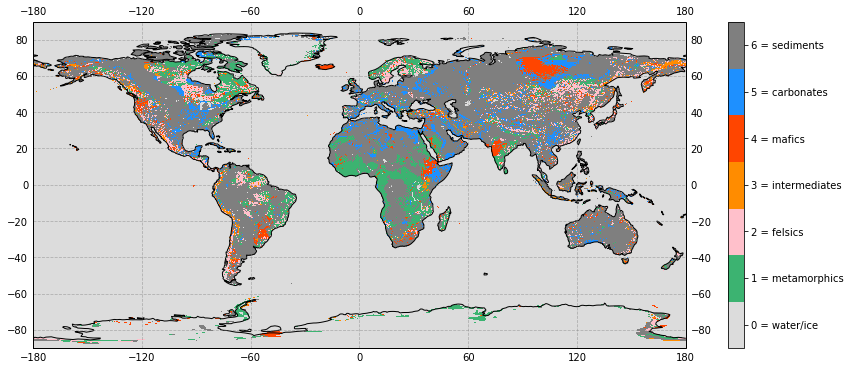

In [8]:
LiMW_Band1 = LiMW.variables['Band1'][:,:].data
LiMW_Band1[LiMW_Band1>6] = 0

LiMW_lat = LiMW.variables['lat'][:].data
LiMW_lon = LiMW.variables['lon'][:].data

plot_lithology(LiMW_Band1, LiMW_lat, LiMW_lon,
               coastlines=True, output=False)

### Lithology Mask

In [9]:
lith_class = ['0 = water/ice',
              '1 = metamorphics',
              '2 = felsics',
              '3 = intermediates',
              '4 = mafics',
              '5 = carbonates',
              '6 = sediments']

#### 180 x 360 resolution

In [10]:
dim_180_360 = (180,360)

lat_180_360 = np.linspace(-89.5,89.5,dim_180_360[0])
lon_180_360 = np.linspace(-179.5,179.5,dim_180_360[1])

# initialize the lithologic mask (lat, lon, lith)
lith_mask_180_360 = np.zeros((dim_180_360[0], dim_180_360[1], 7))

for i in range(dim_180_360[0]):
    for j in range(dim_180_360[1]):
        
        # get the 10x10 cell that fits into the 1x1 degree cell in the lithologic mask
        LiMW_Band1_cell = LiMW_Band1[i*10:(i+1)*10,j*10:(j+1)*10]
        
        # count number of cells of each lithology
        for k in range(7):
            lith_mask_180_360[i,j,k] = np.sum(LiMW_Band1_cell==k)
            
# make the values fraction of the 1x1 cell
lith_mask_180_360 = lith_mask_180_360/100

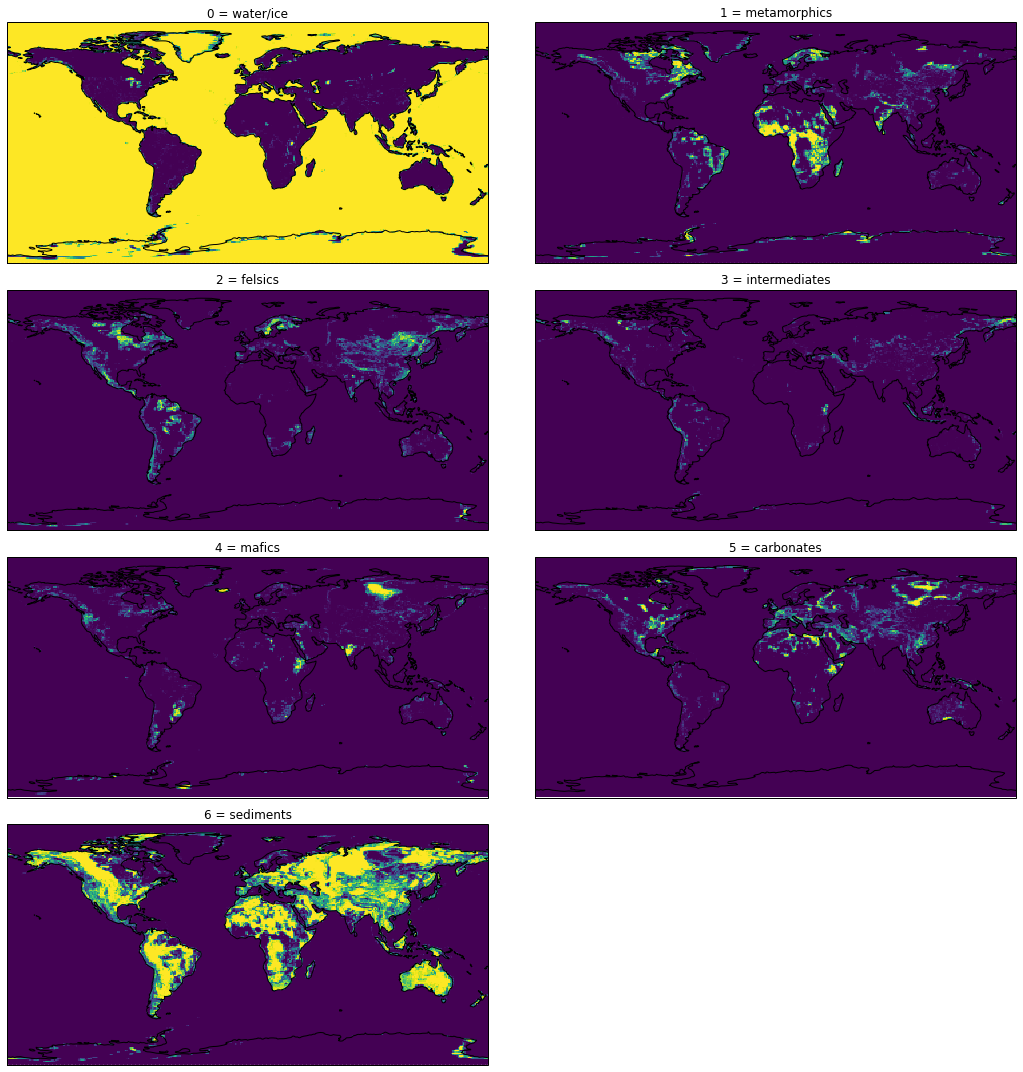

In [11]:
fig = plt.figure(figsize=(15,15))

for i in range(7):
    ax = plt.subplot(4,2,i+1, projection=ccrs.PlateCarree())
    
    z = lith_mask_180_360[:,:,i]
    ax.coastlines()
    im = ax.pcolormesh(lon_180_360, lat_180_360, z, transform=ccrs.PlateCarree())
    
    ax.set_title(lith_class[i])
    
fig.tight_layout()
plt.show(fig)

In [12]:
# initialize netCDF
lith_mask_nc = Dataset('../Output/lith_mask_180_360.nc', 'w', format='NETCDF4')
lith_mask_nc.description = 'lithologic mask: 180x360 resolution.'

# create dimensions
lith_mask_nc.createDimension('lon', dim_180_360[1])
lith_mask_nc.createDimension('lat', dim_180_360[0])
lith_mask_nc.createDimension('lith', 7)

# initialize variables
lon_var = lith_mask_nc.createVariable('lon', 'f', ('lon',))
lat_var = lith_mask_nc.createVariable('lat', 'f', ('lat',))
lith_var = lith_mask_nc.createVariable('lith', 'i', ('lith',))
frac_var = lith_mask_nc.createVariable('frac', 'f', ('lith','lat','lon',), fill_value=1e36)

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
lith_var.long_name = 'lithology'
frac_var.long_name = 'lithology area fraction'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
lith_var.units = 'lithology'
frac_var.units = 'fraction'

lon_var.axis = 'X'
lat_var.axis = 'Y'
lith_var.axis = 'Z'

# fill variables
lon_var[:] = lon_180_360
lat_var[:] = lat_180_360
lith_var[:] = np.arange(7, dtype=np.int8)
frac_var[:,:,:] = np.transpose(lith_mask_180_360.copy(), (2,0,1))
    
lith_mask_nc.close()

#### 360 x 720 resolution

In [13]:
dim_360_720 = (360,720)

lat_360_720 = np.linspace(-89.75,89.75,dim_360_720[0])
lon_360_720 = np.linspace(-179.75,179.75,dim_360_720[1])

# initialize the lithologic mask (lat, lon, lith)
lith_mask_360_720 = np.zeros((dim_360_720[0], dim_360_720[1], 7))

for i in range(dim_360_720[0]):
    for j in range(dim_360_720[1]):
        
        # get the 5x5 cell that fits into the 0.5x0.5 degree cell in the lithologic mask
        LiMW_Band1_cell = LiMW_Band1[i*5:(i+1)*5,j*5:(j+1)*5]
        
        # count number of cells of each lithology
        for k in range(7):
            lith_mask_360_720[i,j,k] = np.sum(LiMW_Band1_cell==k)
            
# make the values fraction of the 1x1 cell
lith_mask_360_720 = lith_mask_360_720/25

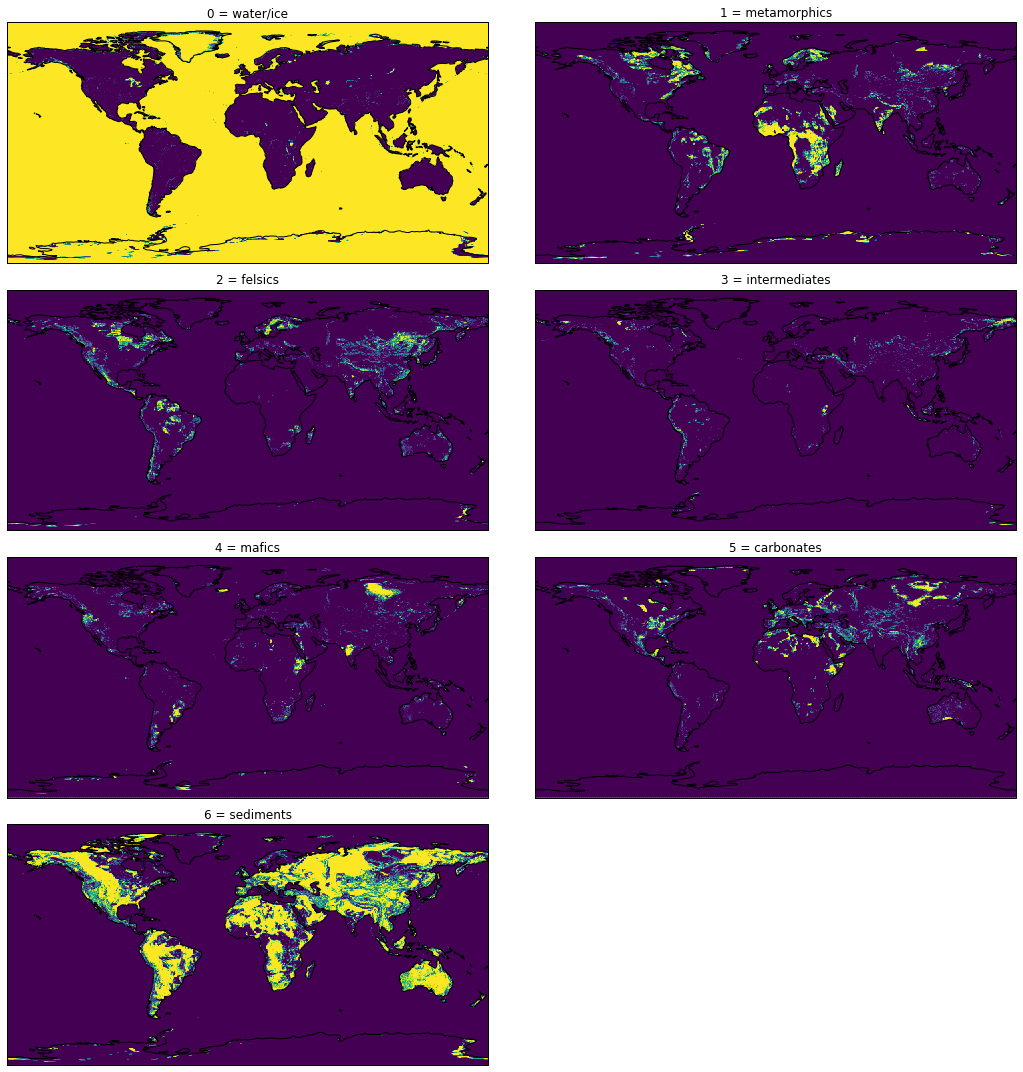

In [14]:
fig = plt.figure(figsize=(15,15))

for i in range(7):
    ax = plt.subplot(4,2,i+1, projection=ccrs.PlateCarree())
    
    z = lith_mask_360_720[:,:,i]
    ax.coastlines()
    im = ax.pcolormesh(lon_360_720, lat_360_720, z, transform=ccrs.PlateCarree())
    
    ax.set_title(lith_class[i])
    
fig.tight_layout()
plt.show(fig)

Output as netCDF:

In [15]:
# initialize netCDF
lith_mask_nc = Dataset('../Output/lith_mask_360_720.nc', 'w', format='NETCDF4')
lith_mask_nc.description = 'lithologic mask: 360x720 resolution.'

# create dimensions
lith_mask_nc.createDimension('lon', dim_360_720[1])
lith_mask_nc.createDimension('lat', dim_360_720[0])
lith_mask_nc.createDimension('lith', 7)

# initialize variables
lon_var = lith_mask_nc.createVariable('lon', 'f', ('lon',))
lat_var = lith_mask_nc.createVariable('lat', 'f', ('lat',))
lith_var = lith_mask_nc.createVariable('lith', 'i', ('lith',))
frac_var = lith_mask_nc.createVariable('frac', 'f', ('lith','lat','lon',), fill_value=1e36)

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
lith_var.long_name = 'lithology'
frac_var.long_name = 'lithology area fraction'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
lith_var.units = 'lithology'
frac_var.units = 'fraction'

lon_var.axis = 'X'
lat_var.axis = 'Y'
lith_var.axis = 'Z'

# fill variables
lon_var[:] = lon_360_720
lat_var[:] = lat_360_720
lith_var[:] = np.arange(7, dtype=np.int8)
frac_var[:,:,:] = np.transpose(lith_mask_360_720.copy(), (2,0,1))
    
lith_mask_nc.close()

## Area

In [16]:
# authalic radius of the Earth in m
Earth_R = 6371.0072 * 1000

### 180 x 360 resolution

In [17]:
# cell area
cell_area_180_360 = np.zeros(shape=dim_180_360)

lat_mins = np.linspace(-90,90,dim_180_360[0]+1)

# iterate through latitudes
for i in range(dim_180_360[0]):
    cell_area_180_360[i] = np.abs(np.sin(np.deg2rad(lat_mins[i]))-np.sin(np.deg2rad(lat_mins[i+1])))*\
                           np.deg2rad(1)*Earth_R**2
    
# land area
land_area_180_360 = cell_area_180_360.copy()
land_area_180_360 = land_area_180_360 * (1 - lith_mask_180_360[:,:,0])

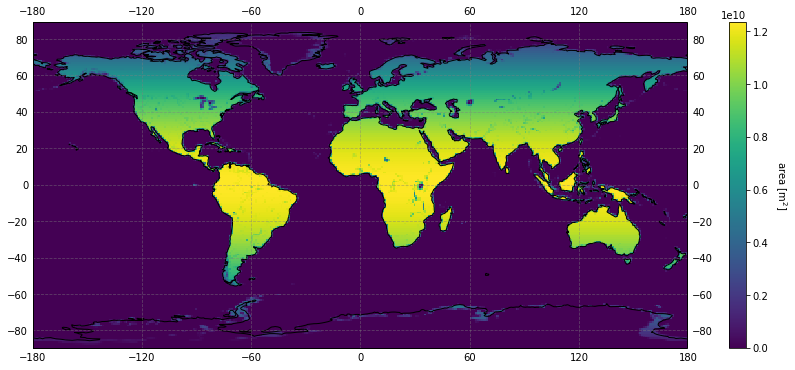

In [18]:
plot_z(land_area_180_360, lat_180_360, lon_180_360, 'area [m$^{2}$]', coastlines=True, output=False)

In [19]:
total_land_area = np.sum(land_area_180_360) / 1e6 / 1e6

total_area_1 = np.sum(lith_mask_180_360[:,:,1] * cell_area_180_360) / 1e6 / 1e6
total_area_2 = np.sum(lith_mask_180_360[:,:,2] * cell_area_180_360) / 1e6 / 1e6
total_area_3 = np.sum(lith_mask_180_360[:,:,3] * cell_area_180_360) / 1e6 / 1e6
total_area_4 = np.sum(lith_mask_180_360[:,:,4] * cell_area_180_360) / 1e6 / 1e6
total_area_5 = np.sum(lith_mask_180_360[:,:,5] * cell_area_180_360) / 1e6 / 1e6
total_area_6 = np.sum(lith_mask_180_360[:,:,6] * cell_area_180_360) / 1e6 / 1e6

print('metamorphic   : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(total_area_1,
                                                                        (total_area_1/total_land_area)*100))
print('felsic        : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(total_area_2,
                                                                        (total_area_2/total_land_area)*100))
print('intermediate  : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(total_area_3,
                                                                        (total_area_3/total_land_area)*100))
print('mafic         : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(total_area_4,
                                                                        (total_area_4/total_land_area)*100))
print('carbonate     : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(total_area_5,
                                                                        (total_area_5/total_land_area)*100))
print('siliciclastic : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(total_area_6,
                                                                        (total_area_6/total_land_area)*100))
print('')
print('total         : area = {0:5.2f} e6 km^2'.format(total_land_area))

metamorphic   : area = 19.65 e6 km^2, perc. = 14.8
felsic        : area = 11.02 e6 km^2, perc. =  8.3
intermediate  : area =  3.16 e6 km^2, perc. =  2.4
mafic         : area =  6.26 e6 km^2, perc. =  4.7
carbonate     : area = 11.32 e6 km^2, perc. =  8.5
siliciclastic : area = 81.67 e6 km^2, perc. = 61.4

total         : area = 133.09 e6 km^2


In [20]:
# initialize netCDF
cell_area_nc = Dataset('../Output/cell_area_180_360.nc', 'w', format='NETCDF4')
cell_area_nc.description = 'Area of each 0.5x0.5 cell: 180x360 resolution.'

# create dimensions
cell_area_nc.createDimension('lon', dim_180_360[1])
cell_area_nc.createDimension('lat', dim_180_360[0])

# initialize variables
lon_var = cell_area_nc.createVariable('lon', 'f', ('lon',))
lat_var = cell_area_nc.createVariable('lat', 'f', ('lat',))
area_var = cell_area_nc.createVariable('area', 'f', ('lat','lon',))

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
area_var.long_name = 'area'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
area_var.units = 'm^2'

lon_var.axis = 'X'
lat_var.axis = 'Y'

# fill variables
lon_var[:] = lon_180_360
lat_var[:] = lat_180_360
area_var[:,:] = cell_area_180_360
    
cell_area_nc.close()

In [21]:
# initialize netCDF
land_area_nc = Dataset('../Output/land_area_180_360.nc', 'w', format='NETCDF4')
land_area_nc.description = 'Area of land in each 0.5x0.5 cell: 180x360 resolution.'

# create dimensions
land_area_nc.createDimension('lon', dim_180_360[1])
land_area_nc.createDimension('lat', dim_180_360[0])

# initialize variables
lon_var = land_area_nc.createVariable('lon', 'f', ('lon',))
lat_var = land_area_nc.createVariable('lat', 'f', ('lat',))
area_var = land_area_nc.createVariable('area', 'f', ('lat','lon',))

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
area_var.long_name = 'area'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
area_var.units = 'm^2'

lon_var.axis = 'X'
lat_var.axis = 'Y'

# fill variables
lon_var[:] = lon_180_360
lat_var[:] = lat_180_360
area_var[:,:] = land_area_180_360
    
land_area_nc.close()

### 360 x 720 resolution

In [22]:
# cell area
cell_area_360_720 = np.zeros(shape=dim_360_720)

lat_mins = np.linspace(-90,90,dim_360_720[0]+1)

# iterate through latitudes
for i in range(dim_360_720[0]):
    cell_area_360_720[i] = np.abs(np.sin(np.deg2rad(lat_mins[i]))-np.sin(np.deg2rad(lat_mins[i+1])))*\
                           np.deg2rad(0.5)*Earth_R**2

# land area
land_area_360_720 = cell_area_360_720.copy()
land_area_360_720 = land_area_360_720 * (1 - lith_mask_360_720[:,:,0])

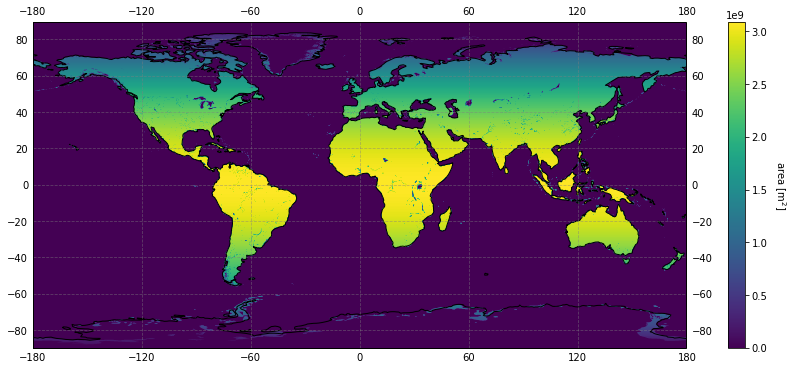

In [23]:
plot_z(land_area_360_720, lat_360_720, lon_360_720, 'area [m$^{2}$]', coastlines=True, output=False)

In [24]:
total_land_area = np.sum(land_area_360_720) / 1e6 / 1e6

total_area_1 = np.sum(lith_mask_360_720[:,:,1] * cell_area_360_720) / 1e6 / 1e6
total_area_2 = np.sum(lith_mask_360_720[:,:,2] * cell_area_360_720) / 1e6 / 1e6
total_area_3 = np.sum(lith_mask_360_720[:,:,3] * cell_area_360_720) / 1e6 / 1e6
total_area_4 = np.sum(lith_mask_360_720[:,:,4] * cell_area_360_720) / 1e6 / 1e6
total_area_5 = np.sum(lith_mask_360_720[:,:,5] * cell_area_360_720) / 1e6 / 1e6
total_area_6 = np.sum(lith_mask_360_720[:,:,6] * cell_area_360_720) / 1e6 / 1e6

print('metamorphic   : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(total_area_1,
                                                                        (total_area_1/total_land_area)*100))
print('felsic        : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(total_area_2,
                                                                        (total_area_2/total_land_area)*100))
print('intermediate  : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(total_area_3,
                                                                        (total_area_3/total_land_area)*100))
print('mafic         : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(total_area_4,
                                                                        (total_area_4/total_land_area)*100))
print('carbonate     : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(total_area_5,
                                                                        (total_area_5/total_land_area)*100))
print('siliciclastic : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(total_area_6,
                                                                        (total_area_6/total_land_area)*100))
print('')
print('total         : area = {0:5.2f} e6 km^2'.format(total_land_area))

metamorphic   : area = 19.65 e6 km^2, perc. = 14.8
felsic        : area = 11.02 e6 km^2, perc. =  8.3
intermediate  : area =  3.16 e6 km^2, perc. =  2.4
mafic         : area =  6.26 e6 km^2, perc. =  4.7
carbonate     : area = 11.32 e6 km^2, perc. =  8.5
siliciclastic : area = 81.67 e6 km^2, perc. = 61.4

total         : area = 133.09 e6 km^2


Output as netCDF:

In [25]:
# initialize netCDF
cell_area_nc = Dataset('../Output/cell_area_360_720.nc', 'w', format='NETCDF4')
cell_area_nc.description = 'Area of each 0.5x0.5 cell: 360x720 resolution.'

# create dimensions
cell_area_nc.createDimension('lon', dim_360_720[1])
cell_area_nc.createDimension('lat', dim_360_720[0])

# initialize variables
lon_var = cell_area_nc.createVariable('lon', 'f', ('lon',))
lat_var = cell_area_nc.createVariable('lat', 'f', ('lat',))
area_var = cell_area_nc.createVariable('area', 'f', ('lat','lon',))

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
area_var.long_name = 'area'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
area_var.units = 'm^2'

lon_var.axis = 'X'
lat_var.axis = 'Y'

# fill variables
lon_var[:] = lon_360_720
lat_var[:] = lat_360_720
area_var[:,:] = cell_area_360_720
    
cell_area_nc.close()

In [26]:
# initialize netCDF
land_area_nc = Dataset('../Output/land_area_360_720.nc', 'w', format='NETCDF4')
land_area_nc.description = 'Area of land in each 0.5x0.5 cell: 360x720 resolution.'

# create dimensions
land_area_nc.createDimension('lon', dim_360_720[1])
land_area_nc.createDimension('lat', dim_360_720[0])

# initialize variables
lon_var = land_area_nc.createVariable('lon', 'f', ('lon',))
lat_var = land_area_nc.createVariable('lat', 'f', ('lat',))
area_var = land_area_nc.createVariable('area', 'f', ('lat','lon',))

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
area_var.long_name = 'area'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
area_var.units = 'm^2'

lon_var.axis = 'X'
lat_var.axis = 'Y'

# fill variables
lon_var[:] = lon_360_720
lat_var[:] = lat_360_720
area_var[:,:] = land_area_360_720
    
land_area_nc.close()

## Indonesia Archipelago

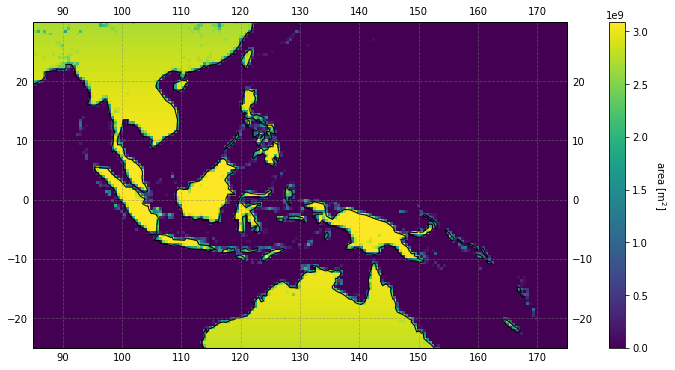

In [27]:
fig, ax = plot_z(land_area_360_720, lat_360_720, lon_360_720, 'area [m$^{2}$]', coastlines=True, output=True)

ax.set_xlim(85,175)
ax.set_ylim(-25,30)

plt.show()

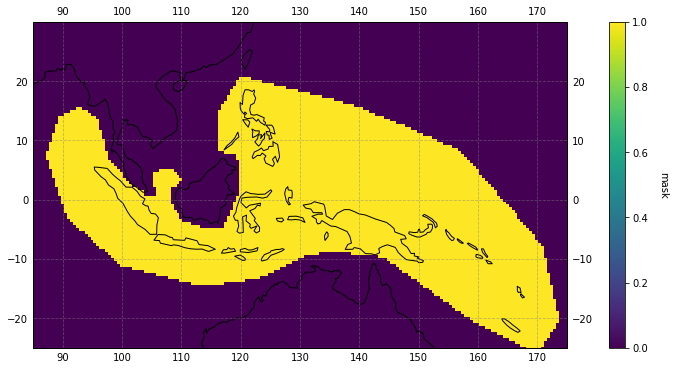

In [28]:
drive_path = '/Users/yuempark/Documents/Berkeley/Research_GEOCLIM/Paleogeo_GEOCLIM/'

IA_mask_nc = Dataset(drive_path + 'Land_Masks/IA_mask.nc')
IA_mask = IA_mask_nc.variables['Band1'][:,:].data
IA_mask[np.isnan(IA_mask)] = 0
IA_mask[IA_mask > 1e30] = 0

fig, ax = plot_z(IA_mask, lat_360_720, lon_360_720, 'mask', coastlines=True, output=True)

ax.set_xlim(85,175)
ax.set_ylim(-25,30)

plt.show()

### noIA = no Indonesia Archipelago

#### lithology

In [29]:
lith_mask_noIA = lith_mask_360_720.copy()

lith_mask_noIA[:,:,0][IA_mask==1] = 1
lith_mask_noIA[:,:,1][IA_mask==1] = 0
lith_mask_noIA[:,:,2][IA_mask==1] = 0
lith_mask_noIA[:,:,3][IA_mask==1] = 0
lith_mask_noIA[:,:,4][IA_mask==1] = 0
lith_mask_noIA[:,:,5][IA_mask==1] = 0
lith_mask_noIA[:,:,6][IA_mask==1] = 0

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  del sys.path[0]


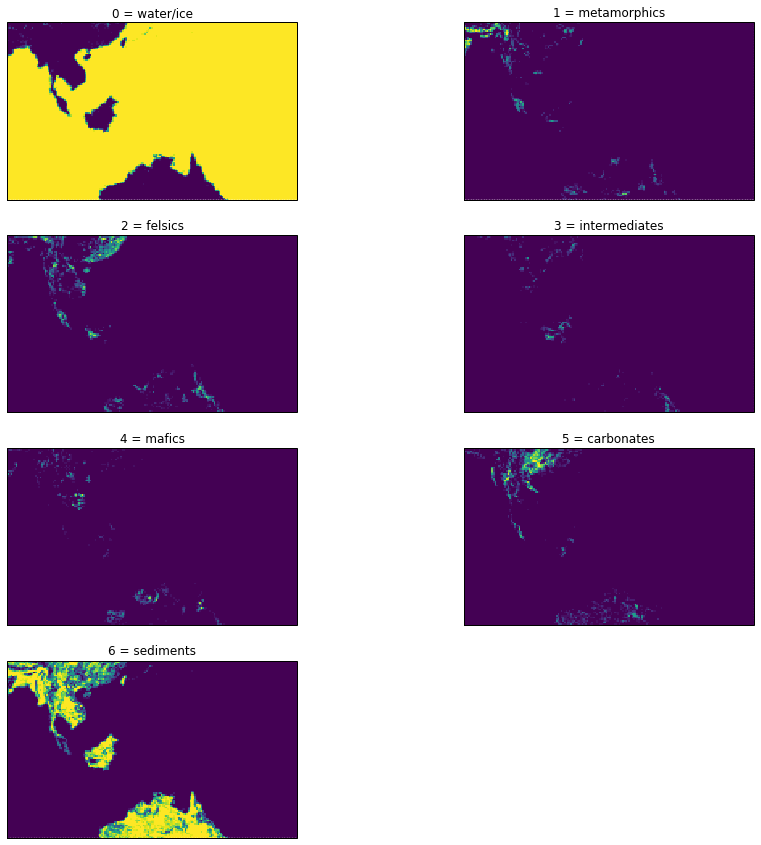

In [30]:
fig = plt.figure(figsize=(15,15))

for i in range(7):
    ax = plt.subplot(4,2,i+1, projection=ccrs.PlateCarree())
    
    z = lith_mask_noIA[:,:,i]
    im = ax.pcolormesh(lon_360_720, lat_360_720, z, transform=ccrs.PlateCarree())
    
    ax.set_title(lith_class[i])
    ax.set_xlim(85,175)
    ax.set_ylim(-25,30)
    
fig.tight_layout()
plt.show(fig)

What gets removed?

In [31]:
IA_mask_land_area = np.sum(IA_mask*land_area_360_720) / 1e6 / 1e6

IA_mask_area_1 = np.sum(lith_mask_360_720[:,:,1]*cell_area_360_720*IA_mask) / 1e6 / 1e6
IA_mask_area_2 = np.sum(lith_mask_360_720[:,:,2]*cell_area_360_720*IA_mask) / 1e6 / 1e6
IA_mask_area_3 = np.sum(lith_mask_360_720[:,:,3]*cell_area_360_720*IA_mask) / 1e6 / 1e6
IA_mask_area_4 = np.sum(lith_mask_360_720[:,:,4]*cell_area_360_720*IA_mask) / 1e6 / 1e6
IA_mask_area_5 = np.sum(lith_mask_360_720[:,:,5]*cell_area_360_720*IA_mask) / 1e6 / 1e6
IA_mask_area_6 = np.sum(lith_mask_360_720[:,:,6]*cell_area_360_720*IA_mask) / 1e6 / 1e6

print('metamorphic   : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(IA_mask_area_1,
                                                                        (IA_mask_area_1/IA_mask_land_area)*100))
print('felsic        : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(IA_mask_area_2,
                                                                        (IA_mask_area_2/IA_mask_land_area)*100))
print('intermediate  : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(IA_mask_area_3,
                                                                        (IA_mask_area_3/IA_mask_land_area)*100))
print('mafic         : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(IA_mask_area_4,
                                                                        (IA_mask_area_4/IA_mask_land_area)*100))
print('carbonate     : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(IA_mask_area_5,
                                                                        (IA_mask_area_5/IA_mask_land_area)*100))
print('siliciclastic : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(IA_mask_area_6,
                                                                        (IA_mask_area_6/IA_mask_land_area)*100))
print('')
print('total         : area = {0:5.2f} e6 km^2'.format(IA_mask_land_area))

metamorphic   : area =  0.10 e6 km^2, perc. =  4.7
felsic        : area =  0.10 e6 km^2, perc. =  4.8
intermediate  : area =  0.24 e6 km^2, perc. = 10.9
mafic         : area =  0.12 e6 km^2, perc. =  5.6
carbonate     : area =  0.29 e6 km^2, perc. = 13.6
siliciclastic : area =  1.31 e6 km^2, perc. = 60.4

total         : area =  2.17 e6 km^2


In [32]:
# initialize netCDF
lith_mask_nc = Dataset('../Output/lith_mask_noIA.nc', 'w', format='NETCDF4')
lith_mask_nc.description = 'lithologic mask: 360x720 resolution, no IA.'

# create dimensions
lith_mask_nc.createDimension('lon', dim_360_720[1])
lith_mask_nc.createDimension('lat', dim_360_720[0])
lith_mask_nc.createDimension('lith', 7)

# initialize variables
lon_var = lith_mask_nc.createVariable('lon', 'f', ('lon',))
lat_var = lith_mask_nc.createVariable('lat', 'f', ('lat',))
lith_var = lith_mask_nc.createVariable('lith', 'i', ('lith',))
frac_var = lith_mask_nc.createVariable('frac', 'f', ('lith','lat','lon',), fill_value=1e36)

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
lith_var.long_name = 'lithology'
frac_var.long_name = 'lithology area fraction'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
lith_var.units = 'lithology'
frac_var.units = 'fraction'

lon_var.axis = 'X'
lat_var.axis = 'Y'
lith_var.axis = 'Z'

# fill variables
lon_var[:] = lon_360_720
lat_var[:] = lat_360_720
lith_var[:] = np.arange(7, dtype=np.int8)
frac_var[:,:,:] = np.transpose(lith_mask_noIA.copy(), (2,0,1))
    
lith_mask_nc.close()

#### land area

In [33]:
land_area_noIA = land_area_360_720.copy()

land_area_noIA[IA_mask==1] = 0

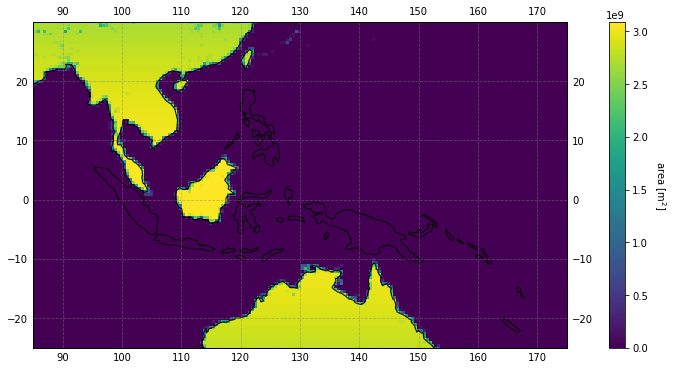

In [34]:
fig, ax = plot_z(land_area_noIA, lat_360_720, lon_360_720, 'area [m$^{2}$]', coastlines=True, output=True)

ax.set_xlim(85,175)
ax.set_ylim(-25,30)

plt.show()

In [35]:
# initialize netCDF
land_area_nc = Dataset('../Output/land_area_noIA.nc', 'w', format='NETCDF4')
land_area_nc.description = 'Area of land in each 0.5x0.5 cell: 360x720 resolution, no IA.'

# create dimensions
land_area_nc.createDimension('lon', dim_360_720[1])
land_area_nc.createDimension('lat', dim_360_720[0])

# initialize variables
lon_var = land_area_nc.createVariable('lon', 'f', ('lon',))
lat_var = land_area_nc.createVariable('lat', 'f', ('lat',))
area_var = land_area_nc.createVariable('area', 'f', ('lat','lon',))

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
area_var.long_name = 'area'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
area_var.units = 'm^2'

lon_var.axis = 'X'
lat_var.axis = 'Y'

# fill variables
lon_var[:] = lon_360_720
lat_var[:] = lat_360_720
area_var[:,:] = land_area_noIA
    
land_area_nc.close()

### redIA = reduced Indonesia Archipelago at 15 Ma

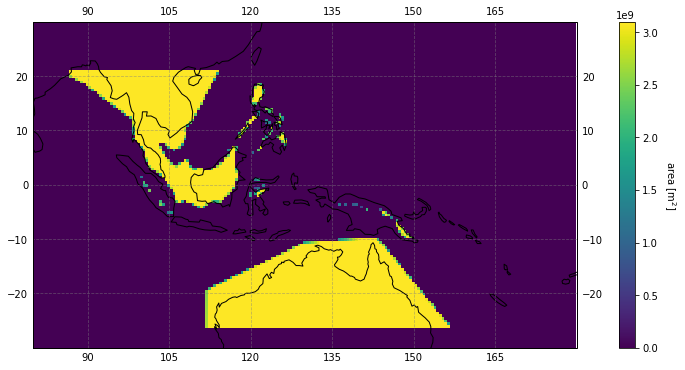

In [36]:
redIA_shoreline_nc = Dataset(drive_path + 'Land_Masks/redIA_shoreline.nc')
redIA_shoreline = redIA_shoreline_nc.variables['Band1'][:,:].data
redIA_shoreline[np.isnan(redIA_shoreline)] = 0
redIA_shoreline[redIA_shoreline > 1e30] = 0

fig, ax = plot_z(redIA_shoreline, lat_360_720, lon_360_720, 'area [m$^{2}$]', coastlines=True, output=True)

ax.set_xlim(80,180)
ax.set_ylim(-30,30)

plt.show()

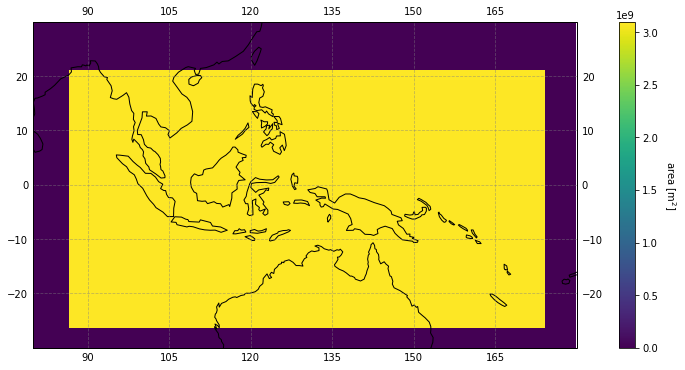

In [37]:
redIA_cell_nc = Dataset(drive_path + 'Land_Masks/redIA_cell.nc')
redIA_cell = redIA_cell_nc.variables['Band1'][:,:].data
redIA_cell[np.isnan(redIA_cell)] = 0
redIA_cell[redIA_cell > 1e30] = 0

fig, ax = plot_z(redIA_cell, lat_360_720, lon_360_720, 'area [m$^{2}$]', coastlines=True, output=True)

ax.set_xlim(80,180)
ax.set_ylim(-30,30)

plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


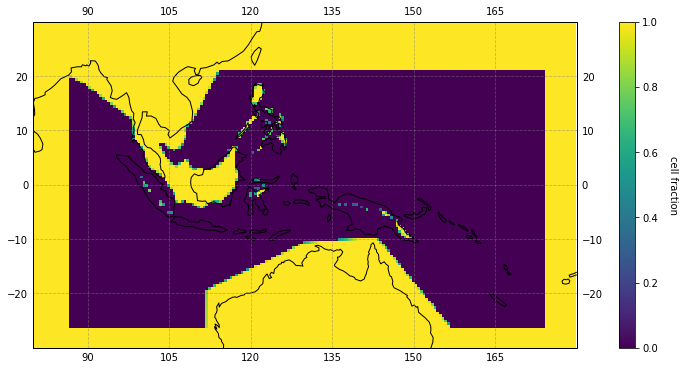

In [38]:
redIA_cell_fraction = redIA_shoreline/redIA_cell
redIA_cell_fraction[np.isnan(redIA_cell_fraction)] = 1
redIA_cell_fraction[redIA_cell_fraction > 1e30] = 1

fig, ax = plot_z(redIA_cell_fraction, lat_360_720, lon_360_720, 'cell fraction', coastlines=True, output=True)

ax.set_xlim(80,180)
ax.set_ylim(-30,30)

plt.show()

#### lithology

In [39]:
lith_mask_redIA = lith_mask_360_720.copy()

lith_mask_redIA[:,:,1] = lith_mask_redIA[:,:,1] * redIA_cell_fraction
lith_mask_redIA[:,:,2] = lith_mask_redIA[:,:,2] * redIA_cell_fraction
lith_mask_redIA[:,:,3] = lith_mask_redIA[:,:,3] * redIA_cell_fraction
lith_mask_redIA[:,:,4] = lith_mask_redIA[:,:,4] * redIA_cell_fraction
lith_mask_redIA[:,:,5] = lith_mask_redIA[:,:,5] * redIA_cell_fraction
lith_mask_redIA[:,:,6] = lith_mask_redIA[:,:,6] * redIA_cell_fraction

lith_mask_redIA[:,:,0] = np.ones(np.shape(lith_mask_redIA[:,:,0])) - np.sum(lith_mask_redIA[:,:,1:], axis=2)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  del sys.path[0]


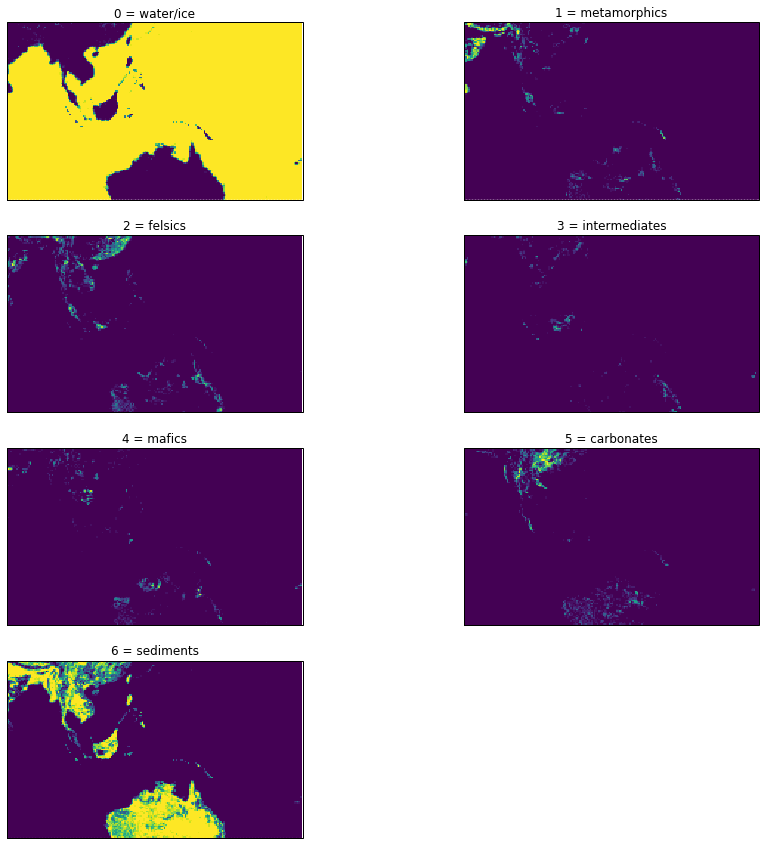

In [40]:
fig = plt.figure(figsize=(15,15))

for i in range(7):
    ax = plt.subplot(4,2,i+1, projection=ccrs.PlateCarree())
    
    z = lith_mask_redIA[:,:,i]
    im = ax.pcolormesh(lon_360_720, lat_360_720, z, transform=ccrs.PlateCarree())
    
    ax.set_title(lith_class[i])
    ax.set_xlim(80,180)
    ax.set_ylim(-30,30)
    
fig.tight_layout()
plt.show(fig)

In [41]:
# initialize netCDF
lith_mask_nc = Dataset('../Output/lith_mask_redIA.nc', 'w', format='NETCDF4')
lith_mask_nc.description = 'lithologic mask: 360x720 resolution, reduced IA.'

# create dimensions
lith_mask_nc.createDimension('lon', dim_360_720[1])
lith_mask_nc.createDimension('lat', dim_360_720[0])
lith_mask_nc.createDimension('lith', 7)

# initialize variables
lon_var = lith_mask_nc.createVariable('lon', 'f', ('lon',))
lat_var = lith_mask_nc.createVariable('lat', 'f', ('lat',))
lith_var = lith_mask_nc.createVariable('lith', 'i', ('lith',))
frac_var = lith_mask_nc.createVariable('frac', 'f', ('lith','lat','lon',), fill_value=1e36)

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
lith_var.long_name = 'lithology'
frac_var.long_name = 'lithology area fraction'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
lith_var.units = 'lithology'
frac_var.units = 'fraction'

lon_var.axis = 'X'
lat_var.axis = 'Y'
lith_var.axis = 'Z'

# fill variables
lon_var[:] = lon_360_720
lat_var[:] = lat_360_720
lith_var[:] = np.arange(7, dtype=np.int8)
frac_var[:,:,:] = np.transpose(lith_mask_redIA.copy(), (2,0,1))
    
lith_mask_nc.close()

#### land area

In [42]:
land_area_redIA = land_area_360_720.copy()

land_area_redIA = land_area_redIA * redIA_cell_fraction

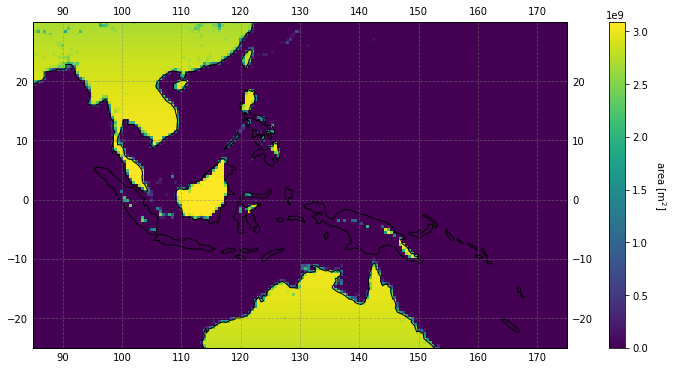

In [43]:
fig, ax = plot_z(land_area_redIA, lat_360_720, lon_360_720, 'area [m$^{2}$]', coastlines=True, output=True)

ax.set_xlim(85,175)
ax.set_ylim(-25,30)

plt.show()

In [44]:
# initialize netCDF
land_area_nc = Dataset('../Output/land_area_redIA.nc', 'w', format='NETCDF4')
land_area_nc.description = 'Area of land in each 0.5x0.5 cell: 360x720 resolution, reduced IA.'

# create dimensions
land_area_nc.createDimension('lon', dim_360_720[1])
land_area_nc.createDimension('lat', dim_360_720[0])

# initialize variables
lon_var = land_area_nc.createVariable('lon', 'f', ('lon',))
lat_var = land_area_nc.createVariable('lat', 'f', ('lat',))
area_var = land_area_nc.createVariable('area', 'f', ('lat','lon',))

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
area_var.long_name = 'area'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
area_var.units = 'm^2'

lon_var.axis = 'X'
lat_var.axis = 'Y'

# fill variables
lon_var[:] = lon_360_720
lat_var[:] = lat_360_720
area_var[:,:] = land_area_redIA
    
land_area_nc.close()

In [45]:
redIA_mask_land_area = total_land_area - (np.sum(land_area_redIA)/1e6/1e6)

redIA_mask_area_1 = total_area_1 - (np.sum(lith_mask_redIA[:,:,1]*cell_area_360_720)/1e6/1e6)
redIA_mask_area_2 = total_area_2 - (np.sum(lith_mask_redIA[:,:,2]*cell_area_360_720)/1e6/1e6)
redIA_mask_area_3 = total_area_3 - (np.sum(lith_mask_redIA[:,:,3]*cell_area_360_720)/1e6/1e6)
redIA_mask_area_4 = total_area_4 - (np.sum(lith_mask_redIA[:,:,4]*cell_area_360_720)/1e6/1e6)
redIA_mask_area_5 = total_area_5 - (np.sum(lith_mask_redIA[:,:,5]*cell_area_360_720)/1e6/1e6)
redIA_mask_area_6 = total_area_6 - (np.sum(lith_mask_redIA[:,:,6]*cell_area_360_720)/1e6/1e6)

print('metamorphic   : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(redIA_mask_area_1,
                                                                        (redIA_mask_area_1/redIA_mask_land_area)*100))
print('felsic        : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(redIA_mask_area_2,
                                                                        (redIA_mask_area_2/redIA_mask_land_area)*100))
print('intermediate  : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(redIA_mask_area_3,
                                                                        (redIA_mask_area_3/redIA_mask_land_area)*100))
print('mafic         : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(redIA_mask_area_4,
                                                                        (redIA_mask_area_4/redIA_mask_land_area)*100))
print('carbonate     : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(redIA_mask_area_5,
                                                                        (redIA_mask_area_5/redIA_mask_land_area)*100))
print('siliciclastic : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(redIA_mask_area_6,
                                                                        (redIA_mask_area_6/redIA_mask_land_area)*100))
print('')
print('total         : area = {0:5.2f} e6 km^2'.format(redIA_mask_land_area))

metamorphic   : area =  0.09 e6 km^2, perc. =  4.2
felsic        : area =  0.09 e6 km^2, perc. =  4.1
intermediate  : area =  0.23 e6 km^2, perc. = 11.1
mafic         : area =  0.10 e6 km^2, perc. =  5.0
carbonate     : area =  0.29 e6 km^2, perc. = 14.0
siliciclastic : area =  1.30 e6 km^2, perc. = 61.7

total         : area =  2.10 e6 km^2


### redIAsunda = reduced Indonesia Archipelago with Sunda Shelf at 15 Ma

#### lithology

In [46]:
lith_mask_redIAsunda = lith_mask_360_720.copy()

lith_mask_redIAsunda[:,:,1] = lith_mask_redIAsunda[:,:,1] * redIA_cell_fraction
lith_mask_redIAsunda[:,:,2] = lith_mask_redIAsunda[:,:,2] * redIA_cell_fraction
lith_mask_redIAsunda[:,:,3] = lith_mask_redIAsunda[:,:,3] * redIA_cell_fraction
lith_mask_redIAsunda[:,:,4] = lith_mask_redIAsunda[:,:,4] * redIA_cell_fraction
lith_mask_redIAsunda[:,:,5] = lith_mask_redIAsunda[:,:,5] * redIA_cell_fraction
lith_mask_redIAsunda[:,:,6] = lith_mask_redIAsunda[:,:,6] * redIA_cell_fraction

lith_mask_redIAsunda[:,:,0] = np.ones(np.shape(lith_mask_redIAsunda[:,:,0])) - np.sum(lith_mask_redIAsunda[:,:,1:], axis=2)

First, just bulk change all 100% ocean pixels in the Sunda Shelf to 50% felsics and 50% sediments - note that this method takes care of the edges of the shelf (where the pixels are not 100% land) already:

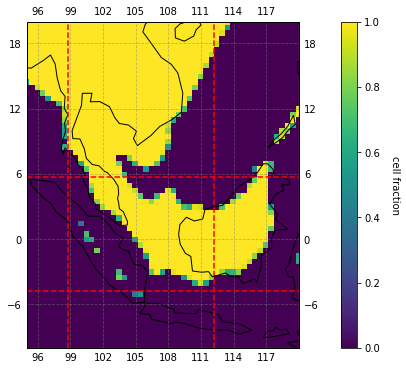

In [47]:
fig, ax = plot_z(redIA_cell_fraction, lat_360_720, lon_360_720, 'cell fraction', coastlines=True, output=True)

ax.set_xlim(95,120)
ax.set_ylim(-10,20)

s_ind = 170
n_ind = 191
w_ind = 557
e_ind = 584
ax.axhline(lat_360_720[s_ind], ls='--', c='red')
ax.axhline(lat_360_720[n_ind], ls='--', c='red')
ax.axvline(lon_360_720[w_ind], ls='--', c='red')
ax.axvline(lon_360_720[e_ind], ls='--', c='red')

plt.show()

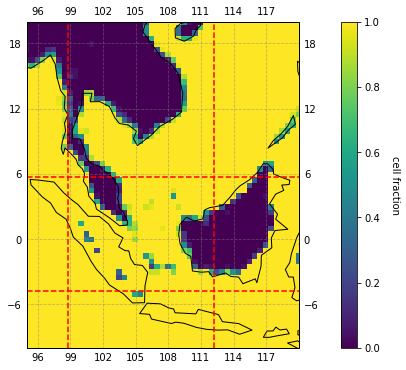

In [48]:
fig, ax = plot_z(lith_mask_redIA[:,:,0], lat_360_720, lon_360_720, 'cell fraction', coastlines=True, output=True)

ax.set_xlim(95,120)
ax.set_ylim(-10,20)

ax.axhline(lat_360_720[s_ind], ls='--', c='red')
ax.axhline(lat_360_720[n_ind], ls='--', c='red')
ax.axvline(lon_360_720[w_ind], ls='--', c='red')
ax.axvline(lon_360_720[e_ind], ls='--', c='red')

plt.show()

In [49]:
for i in range(s_ind, n_ind):
    for j in range(w_ind, e_ind):
        if redIA_cell_fraction[i,j]!=0 and lith_mask_redIAsunda[i,j,0]==1:
            lith_mask_redIAsunda[i,j,0] = 1 - redIA_cell_fraction[i,j]
            lith_mask_redIAsunda[i,j,2] = 0.5 - (lith_mask_redIAsunda[i,j,0]/2)
            lith_mask_redIAsunda[i,j,6] = 0.5 - (lith_mask_redIAsunda[i,j,0]/2)
        elif redIA_cell_fraction[i,j]!=0:
            lith_mask_redIAsunda[i,j,2] = lith_mask_redIAsunda[i,j,2] +\
                                          0.5 * (redIA_cell_fraction[i,j] - (1-lith_mask_redIAsunda[i,j,0]))
            lith_mask_redIAsunda[i,j,6] = lith_mask_redIAsunda[i,j,6] +\
                                          0.5 * (redIA_cell_fraction[i,j] - (1-lith_mask_redIAsunda[i,j,0]))
            lith_mask_redIAsunda[i,j,0] = 1 - redIA_cell_fraction[i,j]

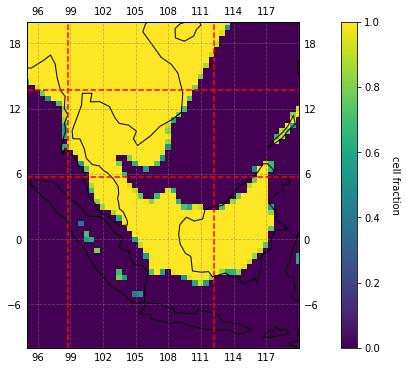

In [50]:
fig, ax = plot_z(redIA_cell_fraction, lat_360_720, lon_360_720, 'cell fraction', coastlines=True, output=True)

ax.set_xlim(95,120)
ax.set_ylim(-10,20)

s_ind = 191
n_ind = 207
w_ind = 557
e_ind = 584
ax.axhline(lat_360_720[s_ind], ls='--', c='red')
ax.axhline(lat_360_720[n_ind], ls='--', c='red')
ax.axvline(lon_360_720[w_ind], ls='--', c='red')
ax.axvline(lon_360_720[e_ind], ls='--', c='red')

plt.show()

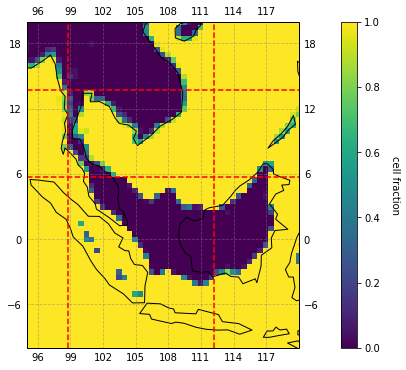

In [51]:
fig, ax = plot_z(lith_mask_redIAsunda[:,:,0], lat_360_720, lon_360_720, 'cell fraction', coastlines=True, output=True)

ax.set_xlim(95,120)
ax.set_ylim(-10,20)

ax.axhline(lat_360_720[s_ind], ls='--', c='red')
ax.axhline(lat_360_720[n_ind], ls='--', c='red')
ax.axvline(lon_360_720[w_ind], ls='--', c='red')
ax.axvline(lon_360_720[e_ind], ls='--', c='red')

plt.show()

In [52]:
for i in range(s_ind, n_ind):
    for j in range(w_ind, e_ind):
        if redIA_cell_fraction[i,j]!=0 and lith_mask_redIAsunda[i,j,0]==1:
            lith_mask_redIAsunda[i,j,0] = 1 - redIA_cell_fraction[i,j]
            lith_mask_redIAsunda[i,j,6] = 1 - lith_mask_redIAsunda[i,j,0]
        elif redIA_cell_fraction[i,j]!=0:
            lith_mask_redIAsunda[i,j,6] = lith_mask_redIAsunda[i,j,6] +\
                                          (redIA_cell_fraction[i,j] - (1-lith_mask_redIAsunda[i,j,0]))
            lith_mask_redIAsunda[i,j,0] = 1 - redIA_cell_fraction[i,j]

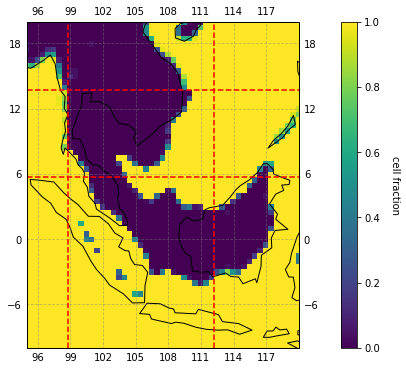

In [53]:
fig, ax = plot_z(lith_mask_redIAsunda[:,:,0], lat_360_720, lon_360_720, 'cell fraction', coastlines=True, output=True)

ax.set_xlim(95,120)
ax.set_ylim(-10,20)

ax.axhline(lat_360_720[s_ind], ls='--', c='red')
ax.axhline(lat_360_720[n_ind], ls='--', c='red')
ax.axvline(lon_360_720[w_ind], ls='--', c='red')
ax.axvline(lon_360_720[e_ind], ls='--', c='red')

plt.show()

Now manually clean up eastern Vietnam (for which we unintentionally added some land):

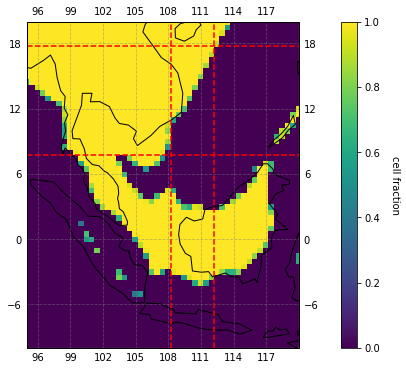

In [54]:
fig, ax = plot_z(redIA_cell_fraction, lat_360_720, lon_360_720, 'cell fraction', coastlines=True, output=True)

ax.set_xlim(95,120)
ax.set_ylim(-10,20)

s_ind = 195
n_ind = 215
w_ind = 576
e_ind = 584
ax.axhline(lat_360_720[s_ind], ls='--', c='red')
ax.axhline(lat_360_720[n_ind], ls='--', c='red')
ax.axvline(lon_360_720[w_ind], ls='--', c='red')
ax.axvline(lon_360_720[e_ind], ls='--', c='red')

plt.show()

In [55]:
for i in range(s_ind, n_ind):
    for j in range(w_ind, e_ind):
        lith_mask_redIAsunda[i,j,0] = lith_mask_redIA[i,j,0]
        lith_mask_redIAsunda[i,j,1] = lith_mask_redIA[i,j,1]
        lith_mask_redIAsunda[i,j,2] = lith_mask_redIA[i,j,2]
        lith_mask_redIAsunda[i,j,3] = lith_mask_redIA[i,j,3]
        lith_mask_redIAsunda[i,j,4] = lith_mask_redIA[i,j,4]
        lith_mask_redIAsunda[i,j,5] = lith_mask_redIA[i,j,5]
        lith_mask_redIAsunda[i,j,6] = lith_mask_redIA[i,j,6]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  


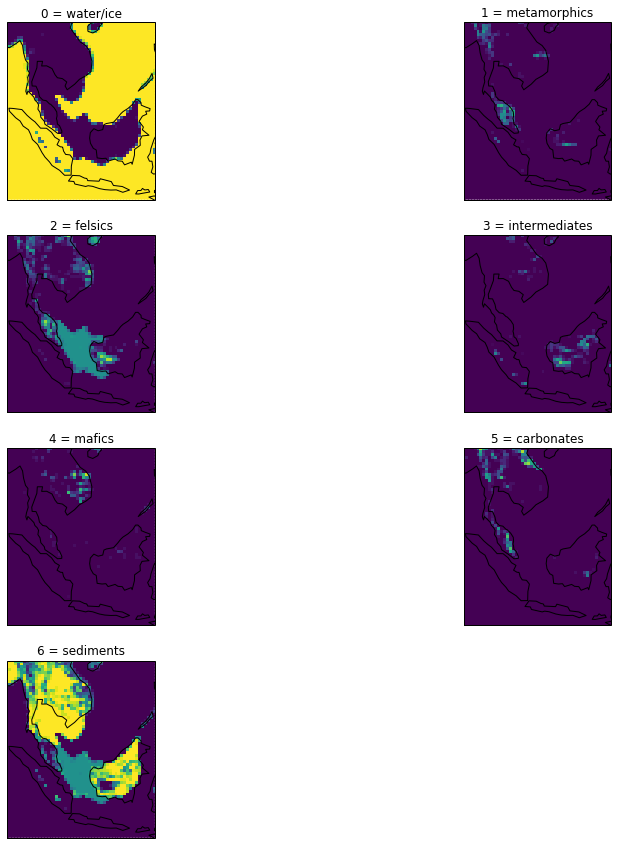

In [56]:
fig = plt.figure(figsize=(15,15))

for i in range(7):
    ax = plt.subplot(4,2,i+1, projection=ccrs.PlateCarree())
    
    z = lith_mask_redIAsunda[:,:,i]
    im = ax.pcolormesh(lon_360_720, lat_360_720, z, transform=ccrs.PlateCarree())
    
    ax.coastlines()
    ax.set_title(lith_class[i])
    ax.set_xlim(95,120)
    ax.set_ylim(-10,20)
    
fig.tight_layout()
plt.show(fig)

In [57]:
# initialize netCDF
lith_mask_nc = Dataset('../Output/lith_mask_redIAsunda.nc', 'w', format='NETCDF4')
lith_mask_nc.description = 'lithologic mask: 360x720 resolution, reduced IA with Sunda Shelf.'

# create dimensions
lith_mask_nc.createDimension('lon', dim_360_720[1])
lith_mask_nc.createDimension('lat', dim_360_720[0])
lith_mask_nc.createDimension('lith', 7)

# initialize variables
lon_var = lith_mask_nc.createVariable('lon', 'f', ('lon',))
lat_var = lith_mask_nc.createVariable('lat', 'f', ('lat',))
lith_var = lith_mask_nc.createVariable('lith', 'i', ('lith',))
frac_var = lith_mask_nc.createVariable('frac', 'f', ('lith','lat','lon',), fill_value=1e36)

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
lith_var.long_name = 'lithology'
frac_var.long_name = 'lithology area fraction'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
lith_var.units = 'lithology'
frac_var.units = 'fraction'

lon_var.axis = 'X'
lat_var.axis = 'Y'
lith_var.axis = 'Z'

# fill variables
lon_var[:] = lon_360_720
lat_var[:] = lat_360_720
lith_var[:] = np.arange(7, dtype=np.int8)
frac_var[:,:,:] = np.transpose(lith_mask_redIAsunda.copy(), (2,0,1))
    
lith_mask_nc.close()

#### land area

In [58]:
land_area_redIAsunda = land_area_redIA.copy()

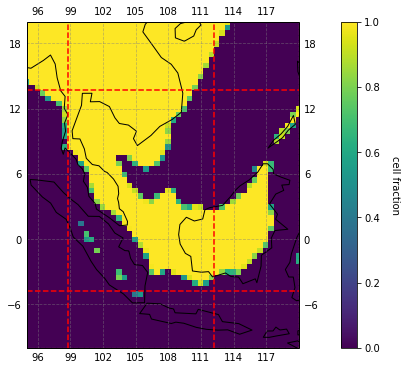

In [59]:
fig, ax = plot_z(redIA_cell_fraction, lat_360_720, lon_360_720, 'cell fraction', coastlines=True, output=True)

ax.set_xlim(95,120)
ax.set_ylim(-10,20)

s_ind = 170
n_ind = 207
w_ind = 557
e_ind = 584
ax.axhline(lat_360_720[s_ind], ls='--', c='red')
ax.axhline(lat_360_720[n_ind], ls='--', c='red')
ax.axvline(lon_360_720[w_ind], ls='--', c='red')
ax.axvline(lon_360_720[e_ind], ls='--', c='red')

plt.show()

In [60]:
for i in range(s_ind, n_ind):
    for j in range(w_ind, e_ind):
        land_area_redIAsunda[i,j] = cell_area_360_720[i,j] * redIA_cell_fraction[i,j]

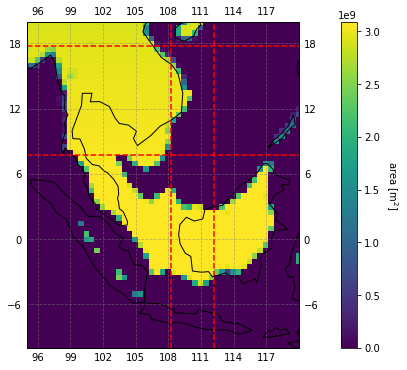

In [61]:
fig, ax = plot_z(land_area_redIAsunda, lat_360_720, lon_360_720, 'area [m$^{2}$]', coastlines=True, output=True)

ax.set_xlim(95,120)
ax.set_ylim(-10,20)

s_ind = 195
n_ind = 215
w_ind = 576
e_ind = 584
ax.axhline(lat_360_720[s_ind], ls='--', c='red')
ax.axhline(lat_360_720[n_ind], ls='--', c='red')
ax.axvline(lon_360_720[w_ind], ls='--', c='red')
ax.axvline(lon_360_720[e_ind], ls='--', c='red')

plt.show()

In [62]:
for i in range(s_ind, n_ind):
    for j in range(w_ind, e_ind):
        land_area_redIAsunda[i,j] = land_area_redIA[i,j]

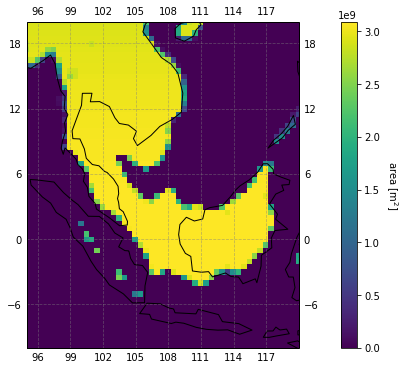

In [63]:
fig, ax = plot_z(land_area_redIAsunda, lat_360_720, lon_360_720, 'area [m$^{2}$]', coastlines=True, output=True)

ax.set_xlim(95,120)
ax.set_ylim(-10,20)

plt.show()

In [64]:
# initialize netCDF
land_area_nc = Dataset('../Output/land_area_redIAsunda.nc', 'w', format='NETCDF4')
land_area_nc.description = 'Area of land in each 0.5x0.5 cell: 360x720 resolution, reduced IA with Sunda Shelf.'

# create dimensions
land_area_nc.createDimension('lon', dim_360_720[1])
land_area_nc.createDimension('lat', dim_360_720[0])

# initialize variables
lon_var = land_area_nc.createVariable('lon', 'f', ('lon',))
lat_var = land_area_nc.createVariable('lat', 'f', ('lat',))
area_var = land_area_nc.createVariable('area', 'f', ('lat','lon',))

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
area_var.long_name = 'area'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
area_var.units = 'm^2'

lon_var.axis = 'X'
lat_var.axis = 'Y'

# fill variables
lon_var[:] = lon_360_720
lat_var[:] = lat_360_720
area_var[:,:] = land_area_redIAsunda
    
land_area_nc.close()

#### slope

In [65]:
raw_slope_nc = Dataset('../Input/pentes_30min.nc')

In [66]:
raw_slope = raw_slope_nc.variables['slope'][:,:].data
raw_slope[raw_slope>1e30] = np.nan

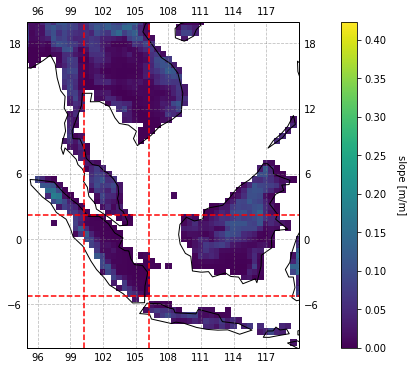

In [67]:
fig, ax = plot_z(raw_slope, lat_360_720, lon_360_720, 'slope [m/m]',
                 coastlines=True, output=True)

ax.set_xlim(95,120)
ax.set_ylim(-10,20)

s_ind = 169
n_ind = 184
w_ind = 560
e_ind = 572
ax.axhline(lat_360_720[s_ind], ls='--', c='red')
ax.axhline(lat_360_720[n_ind], ls='--', c='red')
ax.axvline(lon_360_720[w_ind], ls='--', c='red')
ax.axvline(lon_360_720[e_ind], ls='--', c='red')

plt.show()

In [68]:
flat_area_mask = np.zeros_like(raw_slope)

for i in range(s_ind, n_ind):
    for j in range(w_ind, e_ind):
        if raw_slope[i,j] < 0.01:
            flat_area_mask[i,j] = 1

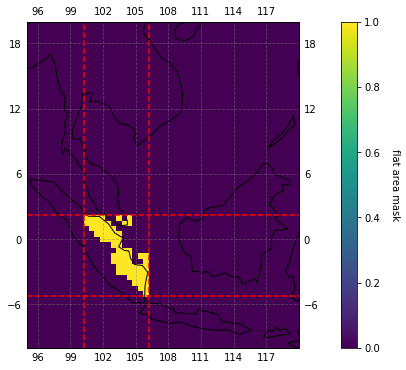

In [69]:
fig, ax = plot_z(flat_area_mask, lat_360_720, lon_360_720, 'flat area mask',
                 coastlines=True, output=True)

ax.set_xlim(95,120)
ax.set_ylim(-10,20)

s_ind = 169
n_ind = 184
w_ind = 560
e_ind = 572
ax.axhline(lat_360_720[s_ind], ls='--', c='red')
ax.axhline(lat_360_720[n_ind], ls='--', c='red')
ax.axvline(lon_360_720[w_ind], ls='--', c='red')
ax.axvline(lon_360_720[e_ind], ls='--', c='red')

plt.show()

In [70]:
flat_area_mean_slope = np.nanmean(raw_slope[flat_area_mask==1])
print('mean slope in the flat areas = {:.4f}'.format(flat_area_mean_slope))

mean slope in the flat areas = 0.0038


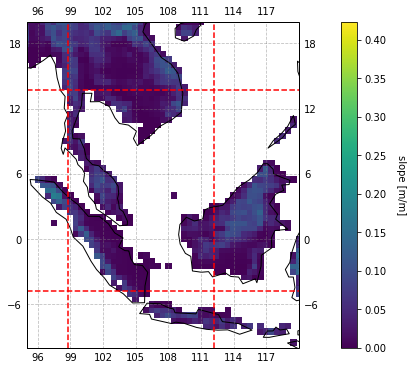

In [71]:
fig, ax = plot_z(raw_slope, lat_360_720, lon_360_720, 'slope [m/m]',
                 coastlines=True, output=True)

ax.set_xlim(95,120)
ax.set_ylim(-10,20)

s_ind = 170
n_ind = 207
w_ind = 557
e_ind = 584
ax.axhline(lat_360_720[s_ind], ls='--', c='red')
ax.axhline(lat_360_720[n_ind], ls='--', c='red')
ax.axvline(lon_360_720[w_ind], ls='--', c='red')
ax.axvline(lon_360_720[e_ind], ls='--', c='red')

plt.show()

In [72]:
slope_redIAsunda = raw_slope.copy()

for i in range(s_ind, n_ind):
    for j in range(w_ind, e_ind):
        if np.isnan(raw_slope[i,j]) and land_area_redIAsunda[i,j]!=0:
            slope_redIAsunda[i,j] = flat_area_mean_slope

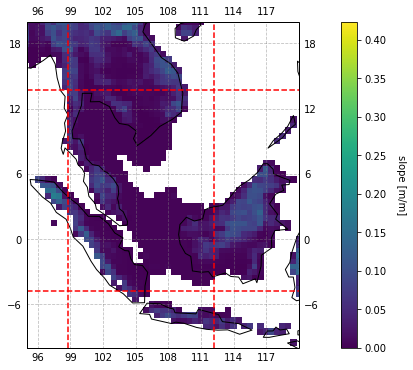

In [73]:
fig, ax = plot_z(slope_redIAsunda, lat_360_720, lon_360_720, 'slope [m/m]',
                 coastlines=True, output=True)

ax.set_xlim(95,120)
ax.set_ylim(-10,20)

s_ind = 170
n_ind = 207
w_ind = 557
e_ind = 584
ax.axhline(lat_360_720[s_ind], ls='--', c='red')
ax.axhline(lat_360_720[n_ind], ls='--', c='red')
ax.axvline(lon_360_720[w_ind], ls='--', c='red')
ax.axvline(lon_360_720[e_ind], ls='--', c='red')

plt.show()

In [74]:
# initialize netCDF
slope_nc = Dataset('../Output/slope_redIAsunda.nc', 'w', format='NETCDF4')
slope_nc.description = 'Slope in each 0.5x0.5 cell: 360x720 resolution, reduced IA with Sunda Shelf.'

# create dimensions
slope_nc.createDimension('lon', dim_360_720[1])
slope_nc.createDimension('lat', dim_360_720[0])

# initialize variables
lon_var = slope_nc.createVariable('lon', 'f', ('lon',))
lat_var = slope_nc.createVariable('lat', 'f', ('lat',))
slope_var = slope_nc.createVariable('slope', 'f', ('lat','lon',), fill_value=1e36)

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
slope_var.long_name = 'slope'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
slope_var.units = 'm/m'

lon_var.axis = 'X'
lat_var.axis = 'Y'

# fill variables
lon_var[:] = lon_360_720
lat_var[:] = lat_360_720

slope_redIAsunda_masked = slope_redIAsunda.copy()
slope_redIAsunda_masked[np.isnan(slope_redIAsunda)] = 1e36
slope_var[:,:] = slope_redIAsunda_masked
    
slope_nc.close()

#### runoff

In [75]:
raw_runoff_nc = Dataset('../Output/GFDL_runoff.nc')

In [76]:
raw_runoff = raw_runoff_nc.variables['rnf'][:,:,:].data
raw_runoff[raw_runoff>1e30] = np.nan

Latitude spacing is 4 inds.

Longitude spacing is 5 inds.

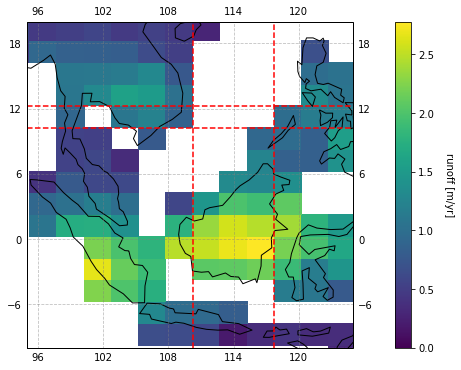

In [77]:
fig, ax = plot_z(raw_runoff[0,:,:], lat_360_720, lon_360_720, 'runoff [m/yr]',
                 coastlines=True, output=True)

ax.set_xlim(95,125)
ax.set_ylim(-10,20)

s_ind = 200
n_ind = 204
w_ind = 580
e_ind = 595
ax.axhline(lat_360_720[s_ind], ls='--', c='red')
ax.axhline(lat_360_720[n_ind], ls='--', c='red')
ax.axvline(lon_360_720[w_ind], ls='--', c='red')
ax.axvline(lon_360_720[e_ind], ls='--', c='red')

plt.show()

In [78]:
def runoff_lin_interp(s_ind, n_ind, w_ind, e_ind, runoff_mask):
    n_empty_blocks = (e_ind - w_ind)/5
    for lvl in np.array([0,1,2]):
        w_val = raw_runoff[lvl,s_ind+1, w_ind-1]
        e_val = raw_runoff[lvl,s_ind+1, e_ind+1]
        block_increment = (e_val - w_val) / n_empty_blocks
        for i in range(s_ind, n_ind):
            for j in range(np.int(n_empty_blocks)):
                runoff_mask[lvl, i, w_ind+(j*5):w_ind+((j+1)*5)] = w_val + (block_increment*(j+1))

In [79]:
runoff_redIAsunda = raw_runoff.copy()

s_ind = 168
n_ind = 172
w_ind = 575
e_ind = 595
runoff_lin_interp(s_ind, n_ind, w_ind, e_ind, runoff_redIAsunda)
            
s_ind = 172
n_ind = 176
w_ind = 575
e_ind = 580
runoff_lin_interp(s_ind, n_ind, w_ind, e_ind, runoff_redIAsunda)
            
s_ind = 180
n_ind = 184
w_ind = 570
e_ind = 575
runoff_lin_interp(s_ind, n_ind, w_ind, e_ind, runoff_redIAsunda)
            
s_ind = 184
n_ind = 188
w_ind = 570
e_ind = 575
runoff_lin_interp(s_ind, n_ind, w_ind, e_ind, runoff_redIAsunda)
            
s_ind = 188
n_ind = 192
w_ind = 570
e_ind = 585
runoff_lin_interp(s_ind, n_ind, w_ind, e_ind, runoff_redIAsunda)

s_ind = 192
n_ind = 196
w_ind = 570
e_ind = 590
runoff_lin_interp(s_ind, n_ind, w_ind, e_ind, runoff_redIAsunda)

s_ind = 196
n_ind = 200
w_ind = 565
e_ind = 570
runoff_lin_interp(s_ind, n_ind, w_ind, e_ind, runoff_redIAsunda)

s_ind = 196
n_ind = 200
w_ind = 575
e_ind = 590
runoff_lin_interp(s_ind, n_ind, w_ind, e_ind, runoff_redIAsunda)

s_ind = 200
n_ind = 204
w_ind = 560
e_ind = 565
runoff_lin_interp(s_ind, n_ind, w_ind, e_ind, runoff_redIAsunda)

s_ind = 200
n_ind = 204
w_ind = 580
e_ind = 595
runoff_lin_interp(s_ind, n_ind, w_ind, e_ind, runoff_redIAsunda)

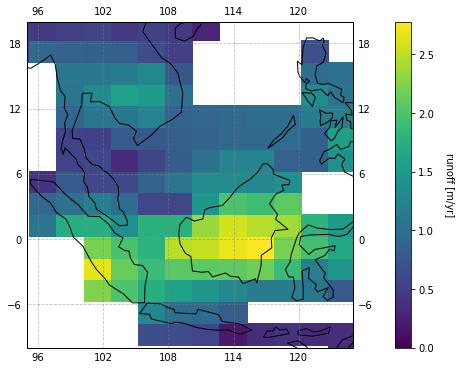

In [80]:
fig, ax = plot_z(runoff_redIAsunda[0,:,:], lat_360_720, lon_360_720, 'runoff [m/yr]',
                 coastlines=True, output=True)

ax.set_xlim(95,125)
ax.set_ylim(-10,20)

plt.show()

In [81]:
# initialize netCDF
runoff_nc = Dataset('../Output/runoff_redIAsunda.nc', 'w', format='NETCDF4')
runoff_nc.description = 'GFDL runoff data interpolated to higher resolution, with zonally interpolated Sunda Shelf.'

# create dimensions
runoff_nc.createDimension('lon', dim_360_720[1])
runoff_nc.createDimension('lat', dim_360_720[0])
runoff_nc.createDimension('lvl', 3)

# initialize variables
lon_var = runoff_nc.createVariable('lon', 'f', ('lon',))
lat_var = runoff_nc.createVariable('lat', 'f', ('lat',))
lvl_var = runoff_nc.createVariable('lvl', 'f', ('lvl',))
rnf_var = runoff_nc.createVariable('rnf', 'f', ('lvl','lat','lon',), fill_value=1e36)

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
lvl_var.long_name = 'CO2'
rnf_var.long_name = 'runoff'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
lvl_var.units = 'ppm'
rnf_var.units = 'm/yr'

lon_var.axis = 'X'
lat_var.axis = 'Y'
lvl_var.axis = 'Z'

# fill variables
lon_var[:] = lon_360_720
lat_var[:] = lat_360_720

CO2s = np.array([286,572,1144])
lvl_var[:] = CO2s

runoff_redIAsunda_masked = runoff_redIAsunda.copy()
runoff_redIAsunda_masked[np.isnan(runoff_redIAsunda_masked)] = 1e36
rnf_var[0,:,:] = runoff_redIAsunda_masked[0,:,:]
rnf_var[1,:,:] = runoff_redIAsunda_masked[1,:,:]
rnf_var[2,:,:] = runoff_redIAsunda_masked[2,:,:]
    
runoff_nc.close()

### IAbcc = replace Indonesia Archipelago mafics/intermediates with bulk continental crust

#### lithology

In [82]:
lith_mask_IAbcc = lith_mask_360_720.copy()

lith_mask_IAbcc[:,:,1][IA_mask==1] = lith_mask_IAbcc[:,:,1][IA_mask==1] +\
                                     lith_mask_IAbcc[:,:,4][IA_mask==1]
lith_mask_IAbcc[:,:,4][IA_mask==1] = 0

lith_mask_IAbcc[:,:,1][IA_mask==1] = lith_mask_IAbcc[:,:,1][IA_mask==1] +\
                                     lith_mask_IAbcc[:,:,3][IA_mask==1]
lith_mask_IAbcc[:,:,3][IA_mask==1] = 0

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  del sys.path[0]


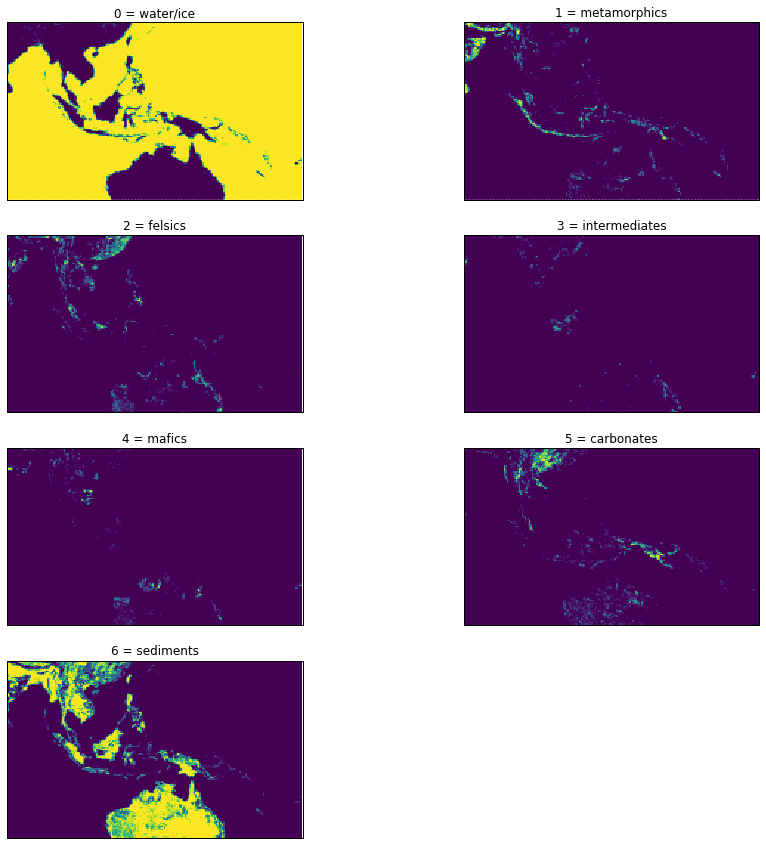

In [83]:
fig = plt.figure(figsize=(15,15))

for i in range(7):
    ax = plt.subplot(4,2,i+1, projection=ccrs.PlateCarree())
    
    z = lith_mask_IAbcc[:,:,i]
    im = ax.pcolormesh(lon_360_720, lat_360_720, z, transform=ccrs.PlateCarree())
    
    ax.set_title(lith_class[i])
    ax.set_xlim(80,180)
    ax.set_ylim(-30,30)
    
fig.tight_layout()
plt.show(fig)

In [84]:
# initialize netCDF
lith_mask_nc = Dataset('../Output/lith_mask_IAbcc.nc', 'w', format='NETCDF4')
lith_mask_nc.description = 'lithologic mask: 360x720 resolution, replace IA felsics/intermediates with metamorphics.'

# create dimensions
lith_mask_nc.createDimension('lon', dim_360_720[1])
lith_mask_nc.createDimension('lat', dim_360_720[0])
lith_mask_nc.createDimension('lith', 7)

# initialize variables
lon_var = lith_mask_nc.createVariable('lon', 'f', ('lon',))
lat_var = lith_mask_nc.createVariable('lat', 'f', ('lat',))
lith_var = lith_mask_nc.createVariable('lith', 'i', ('lith',))
frac_var = lith_mask_nc.createVariable('frac', 'f', ('lith','lat','lon',), fill_value=1e36)

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
lith_var.long_name = 'lithology'
frac_var.long_name = 'lithology area fraction'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
lith_var.units = 'lithology'
frac_var.units = 'fraction'

lon_var.axis = 'X'
lat_var.axis = 'Y'
lith_var.axis = 'Z'

# fill variables
lon_var[:] = lon_360_720
lat_var[:] = lat_360_720
lith_var[:] = np.arange(7, dtype=np.int8)
frac_var[:,:,:] = np.transpose(lith_mask_IAbcc.copy(), (2,0,1))
    
lith_mask_nc.close()

### redIA10 = reduced Indonesia Archipelago at 10 Ma

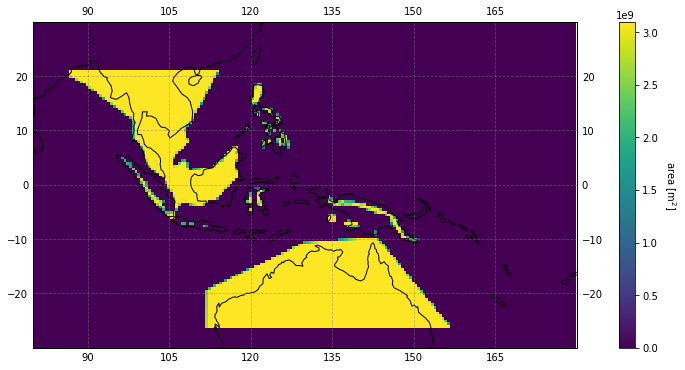

In [85]:
redIA10_shoreline_nc = Dataset(drive_path + 'Land_Masks/redIA_10Ma_shoreline.nc')
redIA10_shoreline = redIA10_shoreline_nc.variables['Band1'][:,:].data
redIA10_shoreline[np.isnan(redIA10_shoreline)] = 0
redIA10_shoreline[redIA10_shoreline > 1e30] = 0

fig, ax = plot_z(redIA10_shoreline, lat_360_720, lon_360_720, 'area [m$^{2}$]', coastlines=True, output=True)

ax.set_xlim(80,180)
ax.set_ylim(-30,30)

plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


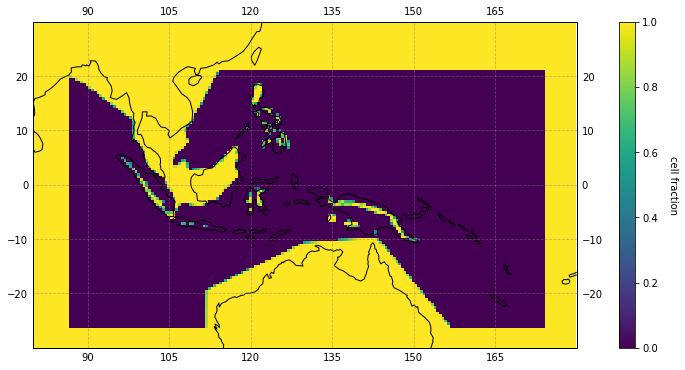

In [86]:
redIA10_cell_fraction = redIA10_shoreline/redIA_cell
redIA10_cell_fraction[np.isnan(redIA10_cell_fraction)] = 1
redIA10_cell_fraction[redIA10_cell_fraction > 1e30] = 1

fig, ax = plot_z(redIA10_cell_fraction, lat_360_720, lon_360_720, 'cell fraction', coastlines=True, output=True)

ax.set_xlim(80,180)
ax.set_ylim(-30,30)

plt.show()

#### lithology

In [87]:
lith_mask_redIA10 = lith_mask_360_720.copy()

lith_mask_redIA10[:,:,1] = lith_mask_redIA10[:,:,1] * redIA10_cell_fraction
lith_mask_redIA10[:,:,2] = lith_mask_redIA10[:,:,2] * redIA10_cell_fraction
lith_mask_redIA10[:,:,3] = lith_mask_redIA10[:,:,3] * redIA10_cell_fraction
lith_mask_redIA10[:,:,4] = lith_mask_redIA10[:,:,4] * redIA10_cell_fraction
lith_mask_redIA10[:,:,5] = lith_mask_redIA10[:,:,5] * redIA10_cell_fraction
lith_mask_redIA10[:,:,6] = lith_mask_redIA10[:,:,6] * redIA10_cell_fraction

lith_mask_redIA10[:,:,0] = np.ones(np.shape(lith_mask_redIA10[:,:,0])) - np.sum(lith_mask_redIA10[:,:,1:], axis=2)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  del sys.path[0]


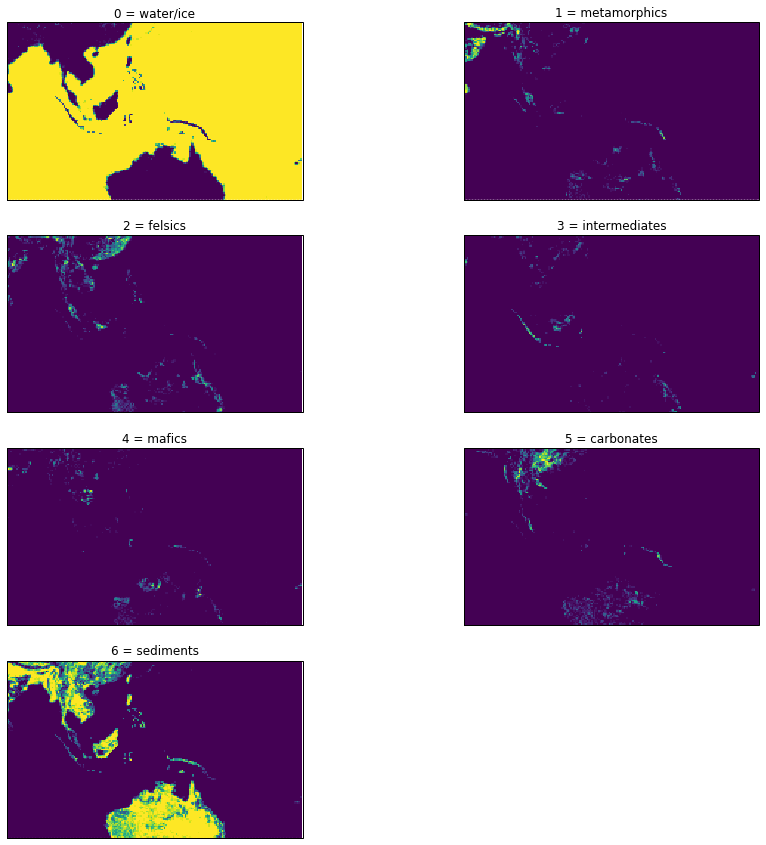

In [88]:
fig = plt.figure(figsize=(15,15))

for i in range(7):
    ax = plt.subplot(4,2,i+1, projection=ccrs.PlateCarree())
    
    z = lith_mask_redIA10[:,:,i]
    im = ax.pcolormesh(lon_360_720, lat_360_720, z, transform=ccrs.PlateCarree())
    
    ax.set_title(lith_class[i])
    ax.set_xlim(80,180)
    ax.set_ylim(-30,30)
    
fig.tight_layout()
plt.show(fig)

In [89]:
# initialize netCDF
lith_mask_nc = Dataset('../Output/lith_mask_redIA10.nc', 'w', format='NETCDF4')
lith_mask_nc.description = 'lithologic mask: 360x720 resolution, reduced IA at 10 Ma.'

# create dimensions
lith_mask_nc.createDimension('lon', dim_360_720[1])
lith_mask_nc.createDimension('lat', dim_360_720[0])
lith_mask_nc.createDimension('lith', 7)

# initialize variables
lon_var = lith_mask_nc.createVariable('lon', 'f', ('lon',))
lat_var = lith_mask_nc.createVariable('lat', 'f', ('lat',))
lith_var = lith_mask_nc.createVariable('lith', 'i', ('lith',))
frac_var = lith_mask_nc.createVariable('frac', 'f', ('lith','lat','lon',), fill_value=1e36)

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
lith_var.long_name = 'lithology'
frac_var.long_name = 'lithology area fraction'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
lith_var.units = 'lithology'
frac_var.units = 'fraction'

lon_var.axis = 'X'
lat_var.axis = 'Y'
lith_var.axis = 'Z'

# fill variables
lon_var[:] = lon_360_720
lat_var[:] = lat_360_720
lith_var[:] = np.arange(7, dtype=np.int8)
frac_var[:,:,:] = np.transpose(lith_mask_redIA10.copy(), (2,0,1))
    
lith_mask_nc.close()

#### land area

In [90]:
land_area_redIA10 = land_area_360_720.copy()

land_area_redIA10 = land_area_redIA10 * redIA10_cell_fraction

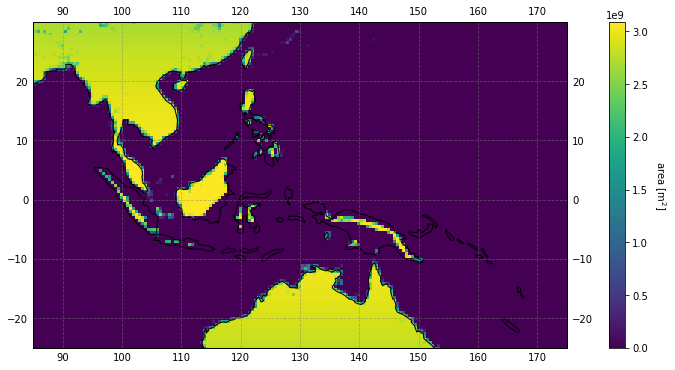

In [91]:
fig, ax = plot_z(land_area_redIA10, lat_360_720, lon_360_720, 'area [m$^{2}$]', coastlines=True, output=True)

ax.set_xlim(85,175)
ax.set_ylim(-25,30)

plt.show()

In [92]:
# initialize netCDF
land_area_nc = Dataset('../Output/land_area_redIA10.nc', 'w', format='NETCDF4')
land_area_nc.description = 'Area of land in each 0.5x0.5 cell: 360x720 resolution, reduced IA at 10 Ma.'

# create dimensions
land_area_nc.createDimension('lon', dim_360_720[1])
land_area_nc.createDimension('lat', dim_360_720[0])

# initialize variables
lon_var = land_area_nc.createVariable('lon', 'f', ('lon',))
lat_var = land_area_nc.createVariable('lat', 'f', ('lat',))
area_var = land_area_nc.createVariable('area', 'f', ('lat','lon',))

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
area_var.long_name = 'area'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
area_var.units = 'm^2'

lon_var.axis = 'X'
lat_var.axis = 'Y'

# fill variables
lon_var[:] = lon_360_720
lat_var[:] = lat_360_720
area_var[:,:] = land_area_redIA10
    
land_area_nc.close()

### redIAsunda10 = reduced Indonesia Archipelago with Sunda Shelf at 10 Ma

#### lithology

In [93]:
lith_mask_redIAsunda10 = lith_mask_360_720.copy()

lith_mask_redIAsunda10[:,:,1] = lith_mask_redIAsunda10[:,:,1] * redIA10_cell_fraction
lith_mask_redIAsunda10[:,:,2] = lith_mask_redIAsunda10[:,:,2] * redIA10_cell_fraction
lith_mask_redIAsunda10[:,:,3] = lith_mask_redIAsunda10[:,:,3] * redIA10_cell_fraction
lith_mask_redIAsunda10[:,:,4] = lith_mask_redIAsunda10[:,:,4] * redIA10_cell_fraction
lith_mask_redIAsunda10[:,:,5] = lith_mask_redIAsunda10[:,:,5] * redIA10_cell_fraction
lith_mask_redIAsunda10[:,:,6] = lith_mask_redIAsunda10[:,:,6] * redIA10_cell_fraction

lith_mask_redIAsunda10[:,:,0] = np.ones(np.shape(lith_mask_redIAsunda10[:,:,0])) - np.sum(lith_mask_redIAsunda10[:,:,1:], axis=2)

First, just bulk change all 100% ocean pixels in the Sunda Shelf to 50% felsics and 50% sediments - note that this method takes care of the edges of the shelf (where the pixels are not 100% land) already:

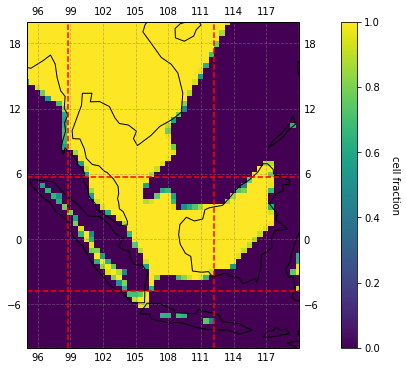

In [94]:
fig, ax = plot_z(redIA10_cell_fraction, lat_360_720, lon_360_720, 'cell fraction', coastlines=True, output=True)

ax.set_xlim(95,120)
ax.set_ylim(-10,20)

s_ind = 170
n_ind = 191
w_ind = 557
e_ind = 584
ax.axhline(lat_360_720[s_ind], ls='--', c='red')
ax.axhline(lat_360_720[n_ind], ls='--', c='red')
ax.axvline(lon_360_720[w_ind], ls='--', c='red')
ax.axvline(lon_360_720[e_ind], ls='--', c='red')

plt.show()

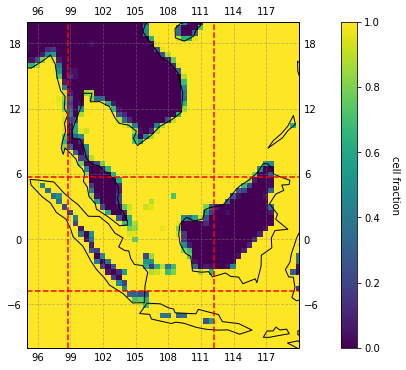

In [95]:
fig, ax = plot_z(lith_mask_redIA10[:,:,0], lat_360_720, lon_360_720, 'cell fraction', coastlines=True, output=True)

ax.set_xlim(95,120)
ax.set_ylim(-10,20)

ax.axhline(lat_360_720[s_ind], ls='--', c='red')
ax.axhline(lat_360_720[n_ind], ls='--', c='red')
ax.axvline(lon_360_720[w_ind], ls='--', c='red')
ax.axvline(lon_360_720[e_ind], ls='--', c='red')

plt.show()

In [96]:
for i in range(s_ind, n_ind):
    for j in range(w_ind, e_ind):
        if redIA10_cell_fraction[i,j]!=0 and lith_mask_redIAsunda10[i,j,0]==1:
            lith_mask_redIAsunda10[i,j,0] = 1 - redIA10_cell_fraction[i,j]
            lith_mask_redIAsunda10[i,j,2] = 0.5 - (lith_mask_redIAsunda10[i,j,0]/2)
            lith_mask_redIAsunda10[i,j,6] = 0.5 - (lith_mask_redIAsunda10[i,j,0]/2)
        elif redIA10_cell_fraction[i,j]!=0:
            lith_mask_redIAsunda10[i,j,2] = lith_mask_redIAsunda10[i,j,2] +\
                                            0.5 * (redIA10_cell_fraction[i,j] - (1-lith_mask_redIAsunda10[i,j,0]))
            lith_mask_redIAsunda10[i,j,6] = lith_mask_redIAsunda10[i,j,6] +\
                                            0.5 * (redIA10_cell_fraction[i,j] - (1-lith_mask_redIAsunda10[i,j,0]))
            lith_mask_redIAsunda10[i,j,0] = 1 - redIA10_cell_fraction[i,j]

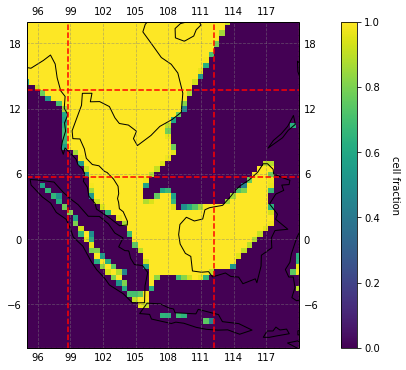

In [97]:
fig, ax = plot_z(redIA10_cell_fraction, lat_360_720, lon_360_720, 'cell fraction', coastlines=True, output=True)

ax.set_xlim(95,120)
ax.set_ylim(-10,20)

s_ind = 191
n_ind = 207
w_ind = 557
e_ind = 584
ax.axhline(lat_360_720[s_ind], ls='--', c='red')
ax.axhline(lat_360_720[n_ind], ls='--', c='red')
ax.axvline(lon_360_720[w_ind], ls='--', c='red')
ax.axvline(lon_360_720[e_ind], ls='--', c='red')

plt.show()

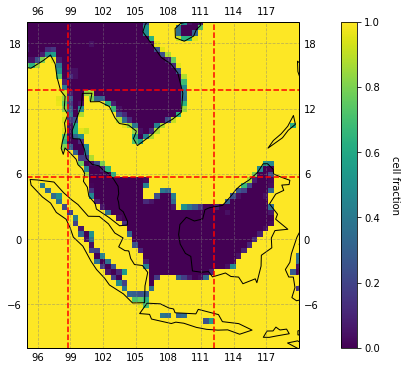

In [98]:
fig, ax = plot_z(lith_mask_redIAsunda10[:,:,0], lat_360_720, lon_360_720, 'cell fraction', coastlines=True, output=True)

ax.set_xlim(95,120)
ax.set_ylim(-10,20)

ax.axhline(lat_360_720[s_ind], ls='--', c='red')
ax.axhline(lat_360_720[n_ind], ls='--', c='red')
ax.axvline(lon_360_720[w_ind], ls='--', c='red')
ax.axvline(lon_360_720[e_ind], ls='--', c='red')

plt.show()

In [99]:
for i in range(s_ind, n_ind):
    for j in range(w_ind, e_ind):
        if redIA10_cell_fraction[i,j]!=0 and lith_mask_redIAsunda10[i,j,0]==1:
            lith_mask_redIAsunda10[i,j,0] = 1 - redIA10_cell_fraction[i,j]
            lith_mask_redIAsunda10[i,j,6] = 1 - lith_mask_redIAsunda10[i,j,0]
        elif redIA10_cell_fraction[i,j]!=0:
            lith_mask_redIAsunda10[i,j,6] = lith_mask_redIAsunda10[i,j,6] +\
                                            (redIA10_cell_fraction[i,j] - (1-lith_mask_redIAsunda10[i,j,0]))
            lith_mask_redIAsunda10[i,j,0] = 1 - redIA10_cell_fraction[i,j]

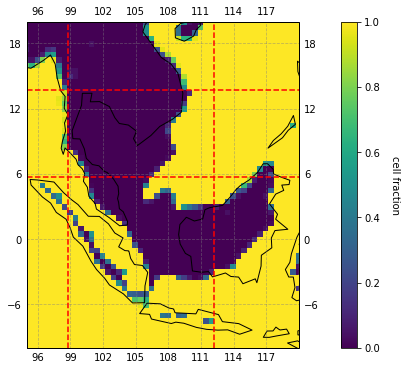

In [100]:
fig, ax = plot_z(lith_mask_redIAsunda10[:,:,0], lat_360_720, lon_360_720, 'cell fraction', coastlines=True, output=True)

ax.set_xlim(95,120)
ax.set_ylim(-10,20)

ax.axhline(lat_360_720[s_ind], ls='--', c='red')
ax.axhline(lat_360_720[n_ind], ls='--', c='red')
ax.axvline(lon_360_720[w_ind], ls='--', c='red')
ax.axvline(lon_360_720[e_ind], ls='--', c='red')

plt.show()

Now manually clean up eastern Vietnam (for which we unintentionally added some land):

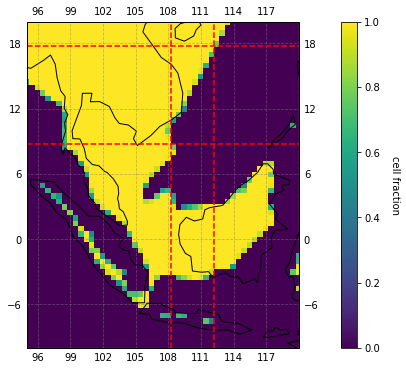

In [101]:
fig, ax = plot_z(redIA10_cell_fraction, lat_360_720, lon_360_720, 'cell fraction', coastlines=True, output=True)

ax.set_xlim(95,120)
ax.set_ylim(-10,20)

s_ind = 197
n_ind = 215
w_ind = 576
e_ind = 584
ax.axhline(lat_360_720[s_ind], ls='--', c='red')
ax.axhline(lat_360_720[n_ind], ls='--', c='red')
ax.axvline(lon_360_720[w_ind], ls='--', c='red')
ax.axvline(lon_360_720[e_ind], ls='--', c='red')

plt.show()

In [102]:
for i in range(s_ind, n_ind):
    for j in range(w_ind, e_ind):
        lith_mask_redIAsunda10[i,j,0] = lith_mask_redIA10[i,j,0]
        lith_mask_redIAsunda10[i,j,1] = lith_mask_redIA10[i,j,1]
        lith_mask_redIAsunda10[i,j,2] = lith_mask_redIA10[i,j,2]
        lith_mask_redIAsunda10[i,j,3] = lith_mask_redIA10[i,j,3]
        lith_mask_redIAsunda10[i,j,4] = lith_mask_redIA10[i,j,4]
        lith_mask_redIAsunda10[i,j,5] = lith_mask_redIA10[i,j,5]
        lith_mask_redIAsunda10[i,j,6] = lith_mask_redIA10[i,j,6]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  


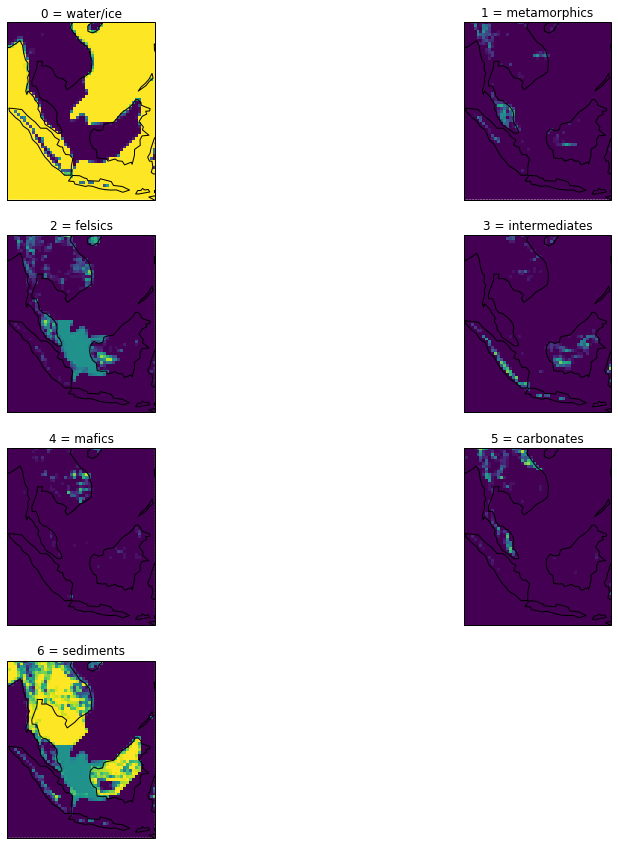

In [103]:
fig = plt.figure(figsize=(15,15))

for i in range(7):
    ax = plt.subplot(4,2,i+1, projection=ccrs.PlateCarree())
    
    z = lith_mask_redIAsunda10[:,:,i]
    im = ax.pcolormesh(lon_360_720, lat_360_720, z, transform=ccrs.PlateCarree())
    
    ax.coastlines()
    ax.set_title(lith_class[i])
    ax.set_xlim(95,120)
    ax.set_ylim(-10,20)
    
fig.tight_layout()
plt.show(fig)

In [104]:
# initialize netCDF
lith_mask_nc = Dataset('../Output/lith_mask_redIAsunda10.nc', 'w', format='NETCDF4')
lith_mask_nc.description = 'lithologic mask: 360x720 resolution, reduced IA with Sunda Shelf at 10 Ma.'

# create dimensions
lith_mask_nc.createDimension('lon', dim_360_720[1])
lith_mask_nc.createDimension('lat', dim_360_720[0])
lith_mask_nc.createDimension('lith', 7)

# initialize variables
lon_var = lith_mask_nc.createVariable('lon', 'f', ('lon',))
lat_var = lith_mask_nc.createVariable('lat', 'f', ('lat',))
lith_var = lith_mask_nc.createVariable('lith', 'i', ('lith',))
frac_var = lith_mask_nc.createVariable('frac', 'f', ('lith','lat','lon',), fill_value=1e36)

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
lith_var.long_name = 'lithology'
frac_var.long_name = 'lithology area fraction'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
lith_var.units = 'lithology'
frac_var.units = 'fraction'

lon_var.axis = 'X'
lat_var.axis = 'Y'
lith_var.axis = 'Z'

# fill variables
lon_var[:] = lon_360_720
lat_var[:] = lat_360_720
lith_var[:] = np.arange(7, dtype=np.int8)
frac_var[:,:,:] = np.transpose(lith_mask_redIAsunda10.copy(), (2,0,1))
    
lith_mask_nc.close()

#### land area

In [105]:
land_area_redIAsunda10 = land_area_redIA10.copy()

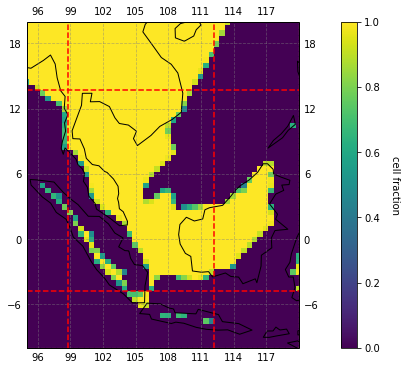

In [106]:
fig, ax = plot_z(redIA10_cell_fraction, lat_360_720, lon_360_720, 'cell fraction', coastlines=True, output=True)

ax.set_xlim(95,120)
ax.set_ylim(-10,20)

s_ind = 170
n_ind = 207
w_ind = 557
e_ind = 584
ax.axhline(lat_360_720[s_ind], ls='--', c='red')
ax.axhline(lat_360_720[n_ind], ls='--', c='red')
ax.axvline(lon_360_720[w_ind], ls='--', c='red')
ax.axvline(lon_360_720[e_ind], ls='--', c='red')

plt.show()

In [107]:
for i in range(s_ind, n_ind):
    for j in range(w_ind, e_ind):
        land_area_redIAsunda10[i,j] = cell_area_360_720[i,j] * redIA10_cell_fraction[i,j]

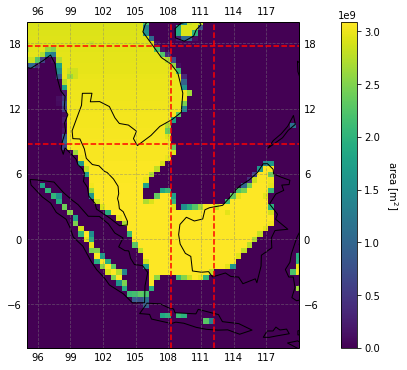

In [108]:
fig, ax = plot_z(land_area_redIAsunda10, lat_360_720, lon_360_720, 'area [m$^{2}$]', coastlines=True, output=True)

ax.set_xlim(95,120)
ax.set_ylim(-10,20)

s_ind = 197
n_ind = 215
w_ind = 576
e_ind = 584
ax.axhline(lat_360_720[s_ind], ls='--', c='red')
ax.axhline(lat_360_720[n_ind], ls='--', c='red')
ax.axvline(lon_360_720[w_ind], ls='--', c='red')
ax.axvline(lon_360_720[e_ind], ls='--', c='red')

plt.show()

In [109]:
for i in range(s_ind, n_ind):
    for j in range(w_ind, e_ind):
        land_area_redIAsunda10[i,j] = land_area_redIA10[i,j]

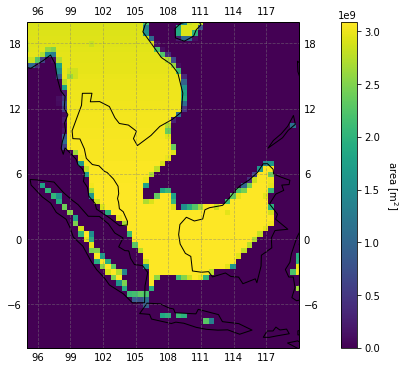

In [110]:
fig, ax = plot_z(land_area_redIAsunda10, lat_360_720, lon_360_720, 'area [m$^{2}$]', coastlines=True, output=True)

ax.set_xlim(95,120)
ax.set_ylim(-10,20)

plt.show()

In [111]:
# initialize netCDF
land_area_nc = Dataset('../Output/land_area_redIAsunda10.nc', 'w', format='NETCDF4')
land_area_nc.description = 'Area of land in each 0.5x0.5 cell: 360x720 resolution, reduced IA with Sunda Shelf at 10 Ma.'

# create dimensions
land_area_nc.createDimension('lon', dim_360_720[1])
land_area_nc.createDimension('lat', dim_360_720[0])

# initialize variables
lon_var = land_area_nc.createVariable('lon', 'f', ('lon',))
lat_var = land_area_nc.createVariable('lat', 'f', ('lat',))
area_var = land_area_nc.createVariable('area', 'f', ('lat','lon',))

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
area_var.long_name = 'area'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
area_var.units = 'm^2'

lon_var.axis = 'X'
lat_var.axis = 'Y'

# fill variables
lon_var[:] = lon_360_720
lat_var[:] = lat_360_720
area_var[:,:] = land_area_redIAsunda10
    
land_area_nc.close()

#### slope

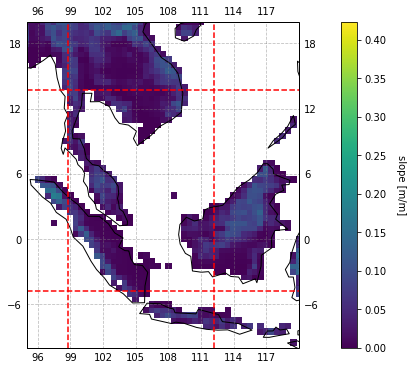

In [112]:
fig, ax = plot_z(raw_slope, lat_360_720, lon_360_720, 'slope [m/m]',
                 coastlines=True, output=True)

ax.set_xlim(95,120)
ax.set_ylim(-10,20)

s_ind = 170
n_ind = 207
w_ind = 557
e_ind = 584
ax.axhline(lat_360_720[s_ind], ls='--', c='red')
ax.axhline(lat_360_720[n_ind], ls='--', c='red')
ax.axvline(lon_360_720[w_ind], ls='--', c='red')
ax.axvline(lon_360_720[e_ind], ls='--', c='red')

plt.show()

In [113]:
slope_redIAsunda10 = raw_slope.copy()

for i in range(s_ind, n_ind):
    for j in range(w_ind, e_ind):
        if np.isnan(raw_slope[i,j]) and land_area_redIAsunda10[i,j]!=0:
            slope_redIAsunda10[i,j] = flat_area_mean_slope

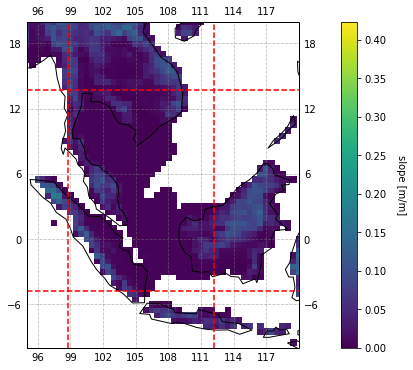

In [114]:
fig, ax = plot_z(slope_redIAsunda10, lat_360_720, lon_360_720, 'slope [m/m]',
                 coastlines=True, output=True)

ax.set_xlim(95,120)
ax.set_ylim(-10,20)

s_ind = 170
n_ind = 207
w_ind = 557
e_ind = 584
ax.axhline(lat_360_720[s_ind], ls='--', c='red')
ax.axhline(lat_360_720[n_ind], ls='--', c='red')
ax.axvline(lon_360_720[w_ind], ls='--', c='red')
ax.axvline(lon_360_720[e_ind], ls='--', c='red')

plt.show()

In [115]:
# initialize netCDF
slope_nc = Dataset('../Output/slope_redIAsunda10.nc', 'w', format='NETCDF4')
slope_nc.description = 'Slope in each 0.5x0.5 cell: 360x720 resolution, reduced IA with Sunda Shelf at 10 Ma.'

# create dimensions
slope_nc.createDimension('lon', dim_360_720[1])
slope_nc.createDimension('lat', dim_360_720[0])

# initialize variables
lon_var = slope_nc.createVariable('lon', 'f', ('lon',))
lat_var = slope_nc.createVariable('lat', 'f', ('lat',))
slope_var = slope_nc.createVariable('slope', 'f', ('lat','lon',), fill_value=1e36)

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
slope_var.long_name = 'slope'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
slope_var.units = 'm/m'

lon_var.axis = 'X'
lat_var.axis = 'Y'

# fill variables
lon_var[:] = lon_360_720
lat_var[:] = lat_360_720

slope_redIAsunda10_masked = slope_redIAsunda10.copy()
slope_redIAsunda10_masked[np.isnan(slope_redIAsunda10)] = 1e36
slope_var[:,:] = slope_redIAsunda10_masked
    
slope_nc.close()

#### runoff

Latitude spacing is 4 inds.

Longitude spacing is 5 inds.

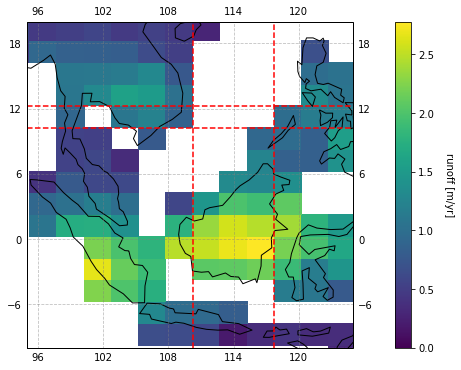

In [116]:
fig, ax = plot_z(raw_runoff[0,:,:], lat_360_720, lon_360_720, 'runoff [m/yr]',
                 coastlines=True, output=True)

ax.set_xlim(95,125)
ax.set_ylim(-10,20)

s_ind = 200
n_ind = 204
w_ind = 580
e_ind = 595
ax.axhline(lat_360_720[s_ind], ls='--', c='red')
ax.axhline(lat_360_720[n_ind], ls='--', c='red')
ax.axvline(lon_360_720[w_ind], ls='--', c='red')
ax.axvline(lon_360_720[e_ind], ls='--', c='red')

plt.show()

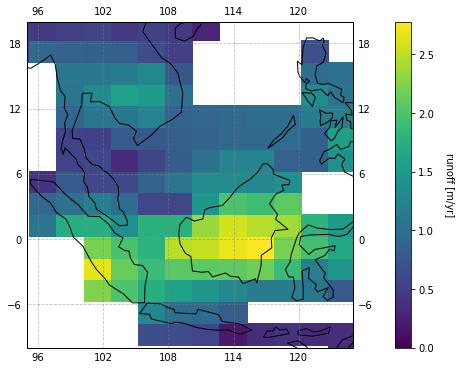

In [117]:
runoff_redIAsunda10 = runoff_redIAsunda.copy()

fig, ax = plot_z(runoff_redIAsunda10[0,:,:], lat_360_720, lon_360_720, 'runoff [m/yr]',
                 coastlines=True, output=True)

ax.set_xlim(95,125)
ax.set_ylim(-10,20)

plt.show()

In [118]:
# initialize netCDF
runoff_nc = Dataset('../Output/runoff_redIAsunda10.nc', 'w', format='NETCDF4')
runoff_nc.description = 'GFDL runoff data interpolated to higher resolution, with zonally interpolated Sunda Shelf at 10 Ma.'

# create dimensions
runoff_nc.createDimension('lon', dim_360_720[1])
runoff_nc.createDimension('lat', dim_360_720[0])
runoff_nc.createDimension('lvl', 3)

# initialize variables
lon_var = runoff_nc.createVariable('lon', 'f', ('lon',))
lat_var = runoff_nc.createVariable('lat', 'f', ('lat',))
lvl_var = runoff_nc.createVariable('lvl', 'f', ('lvl',))
rnf_var = runoff_nc.createVariable('rnf', 'f', ('lvl','lat','lon',), fill_value=1e36)

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
lvl_var.long_name = 'CO2'
rnf_var.long_name = 'runoff'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
lvl_var.units = 'ppm'
rnf_var.units = 'm/yr'

lon_var.axis = 'X'
lat_var.axis = 'Y'
lvl_var.axis = 'Z'

# fill variables
lon_var[:] = lon_360_720
lat_var[:] = lat_360_720

CO2s = np.array([286,572,1144])
lvl_var[:] = CO2s

runoff_redIAsunda10_masked = runoff_redIAsunda10.copy()
runoff_redIAsunda10_masked[np.isnan(runoff_redIAsunda10_masked)] = 1e36
rnf_var[0,:,:] = runoff_redIAsunda10_masked[0,:,:]
rnf_var[1,:,:] = runoff_redIAsunda10_masked[1,:,:]
rnf_var[2,:,:] = runoff_redIAsunda10_masked[2,:,:]
    
runoff_nc.close()

### redIA5 = reduced Indonesia Archipelago at 5 Ma

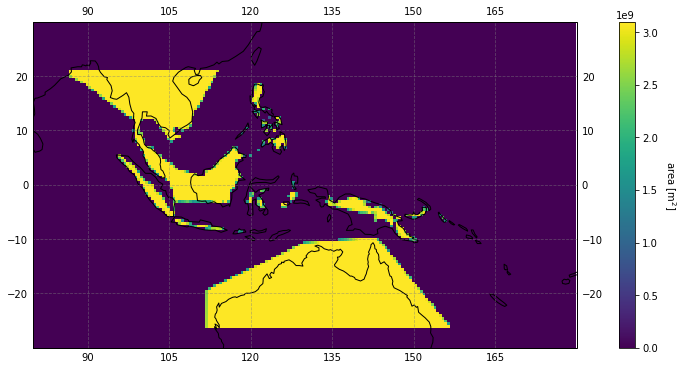

In [119]:
redIA5_shoreline_nc = Dataset(drive_path + 'Land_Masks/redIA_5Ma_shoreline.nc')
redIA5_shoreline = redIA5_shoreline_nc.variables['Band1'][:,:].data
redIA5_shoreline[np.isnan(redIA5_shoreline)] = 0
redIA5_shoreline[redIA5_shoreline > 1e30] = 0

fig, ax = plot_z(redIA5_shoreline, lat_360_720, lon_360_720, 'area [m$^{2}$]', coastlines=True, output=True)

ax.set_xlim(80,180)
ax.set_ylim(-30,30)

plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


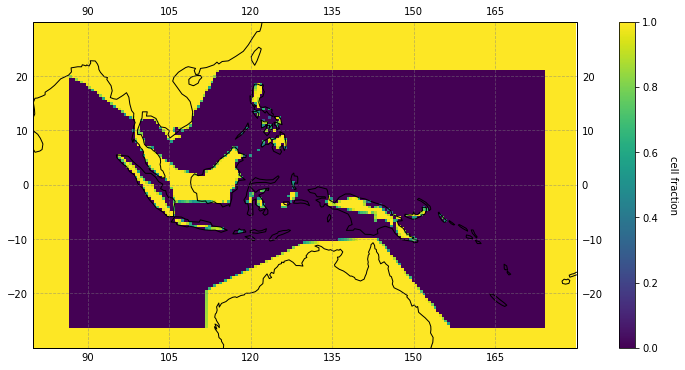

In [120]:
redIA5_cell_fraction = redIA5_shoreline/redIA_cell
redIA5_cell_fraction[np.isnan(redIA5_cell_fraction)] = 1
redIA5_cell_fraction[redIA5_cell_fraction > 1e30] = 1

fig, ax = plot_z(redIA5_cell_fraction, lat_360_720, lon_360_720, 'cell fraction', coastlines=True, output=True)

ax.set_xlim(80,180)
ax.set_ylim(-30,30)

plt.show()

#### lithology

In [121]:
lith_mask_redIA5 = lith_mask_360_720.copy()

lith_mask_redIA5[:,:,1] = lith_mask_redIA5[:,:,1] * redIA5_cell_fraction
lith_mask_redIA5[:,:,2] = lith_mask_redIA5[:,:,2] * redIA5_cell_fraction
lith_mask_redIA5[:,:,3] = lith_mask_redIA5[:,:,3] * redIA5_cell_fraction
lith_mask_redIA5[:,:,4] = lith_mask_redIA5[:,:,4] * redIA5_cell_fraction
lith_mask_redIA5[:,:,5] = lith_mask_redIA5[:,:,5] * redIA5_cell_fraction
lith_mask_redIA5[:,:,6] = lith_mask_redIA5[:,:,6] * redIA5_cell_fraction

lith_mask_redIA5[:,:,0] = np.ones(np.shape(lith_mask_redIA5[:,:,0])) - np.sum(lith_mask_redIA5[:,:,1:], axis=2)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  del sys.path[0]


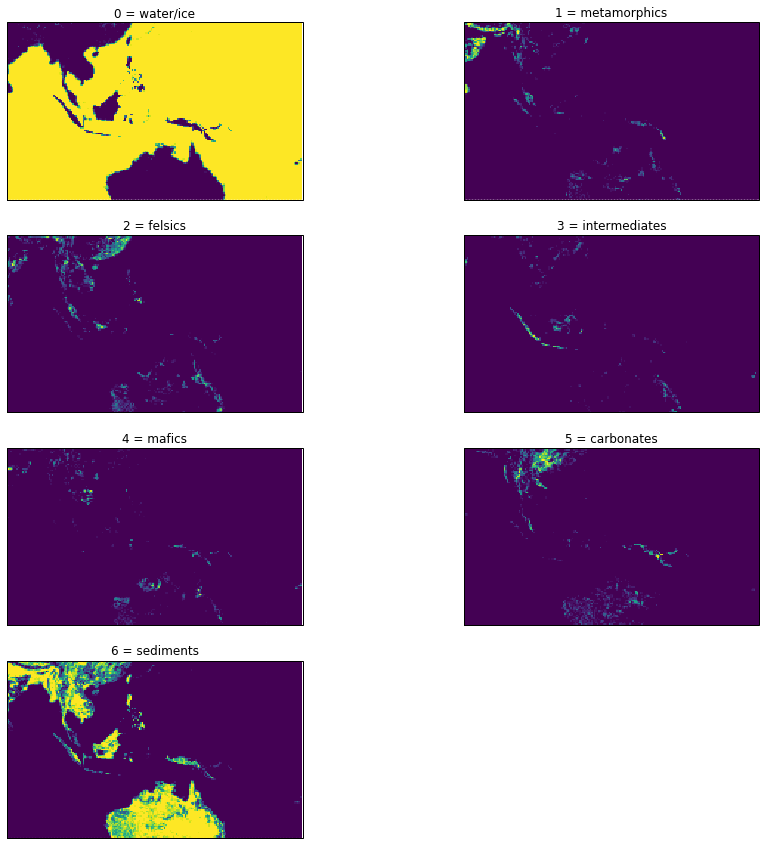

In [122]:
fig = plt.figure(figsize=(15,15))

for i in range(7):
    ax = plt.subplot(4,2,i+1, projection=ccrs.PlateCarree())
    
    z = lith_mask_redIA5[:,:,i]
    im = ax.pcolormesh(lon_360_720, lat_360_720, z, transform=ccrs.PlateCarree())
    
    ax.set_title(lith_class[i])
    ax.set_xlim(80,180)
    ax.set_ylim(-30,30)
    
fig.tight_layout()
plt.show(fig)

In [123]:
# initialize netCDF
lith_mask_nc = Dataset('../Output/lith_mask_redIA5.nc', 'w', format='NETCDF4')
lith_mask_nc.description = 'lithologic mask: 360x720 resolution, reduced IA at 5 Ma.'

# create dimensions
lith_mask_nc.createDimension('lon', dim_360_720[1])
lith_mask_nc.createDimension('lat', dim_360_720[0])
lith_mask_nc.createDimension('lith', 7)

# initialize variables
lon_var = lith_mask_nc.createVariable('lon', 'f', ('lon',))
lat_var = lith_mask_nc.createVariable('lat', 'f', ('lat',))
lith_var = lith_mask_nc.createVariable('lith', 'i', ('lith',))
frac_var = lith_mask_nc.createVariable('frac', 'f', ('lith','lat','lon',), fill_value=1e36)

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
lith_var.long_name = 'lithology'
frac_var.long_name = 'lithology area fraction'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
lith_var.units = 'lithology'
frac_var.units = 'fraction'

lon_var.axis = 'X'
lat_var.axis = 'Y'
lith_var.axis = 'Z'

# fill variables
lon_var[:] = lon_360_720
lat_var[:] = lat_360_720
lith_var[:] = np.arange(7, dtype=np.int8)
frac_var[:,:,:] = np.transpose(lith_mask_redIA5.copy(), (2,0,1))
    
lith_mask_nc.close()

#### land area

In [124]:
land_area_redIA5 = land_area_360_720.copy()

land_area_redIA5 = land_area_redIA5 * redIA5_cell_fraction

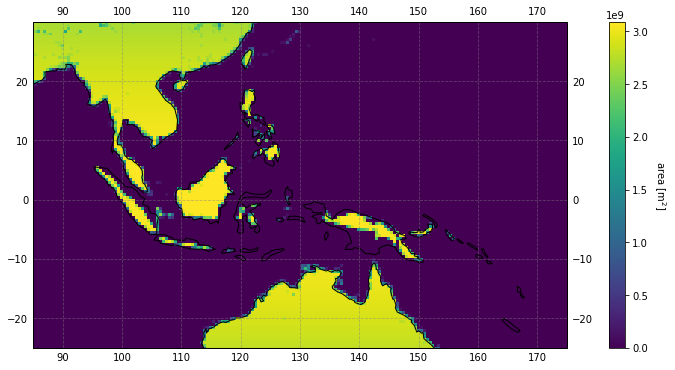

In [125]:
fig, ax = plot_z(land_area_redIA5, lat_360_720, lon_360_720, 'area [m$^{2}$]', coastlines=True, output=True)

ax.set_xlim(85,175)
ax.set_ylim(-25,30)

plt.show()

In [126]:
# initialize netCDF
land_area_nc = Dataset('../Output/land_area_redIA5.nc', 'w', format='NETCDF4')
land_area_nc.description = 'Area of land in each 0.5x0.5 cell: 360x720 resolution, reduced IA at 5 Ma.'

# create dimensions
land_area_nc.createDimension('lon', dim_360_720[1])
land_area_nc.createDimension('lat', dim_360_720[0])

# initialize variables
lon_var = land_area_nc.createVariable('lon', 'f', ('lon',))
lat_var = land_area_nc.createVariable('lat', 'f', ('lat',))
area_var = land_area_nc.createVariable('area', 'f', ('lat','lon',))

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
area_var.long_name = 'area'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
area_var.units = 'm^2'

lon_var.axis = 'X'
lat_var.axis = 'Y'

# fill variables
lon_var[:] = lon_360_720
lat_var[:] = lat_360_720
area_var[:,:] = land_area_redIA5
    
land_area_nc.close()

### redIAsunda5 = reduced Indonesia Archipelago with Sunda Shelf at 5 Ma

#### lithology

In [127]:
lith_mask_redIAsunda5 = lith_mask_360_720.copy()

lith_mask_redIAsunda5[:,:,1] = lith_mask_redIAsunda5[:,:,1] * redIA5_cell_fraction
lith_mask_redIAsunda5[:,:,2] = lith_mask_redIAsunda5[:,:,2] * redIA5_cell_fraction
lith_mask_redIAsunda5[:,:,3] = lith_mask_redIAsunda5[:,:,3] * redIA5_cell_fraction
lith_mask_redIAsunda5[:,:,4] = lith_mask_redIAsunda5[:,:,4] * redIA5_cell_fraction
lith_mask_redIAsunda5[:,:,5] = lith_mask_redIAsunda5[:,:,5] * redIA5_cell_fraction
lith_mask_redIAsunda5[:,:,6] = lith_mask_redIAsunda5[:,:,6] * redIA5_cell_fraction

lith_mask_redIAsunda5[:,:,0] = np.ones(np.shape(lith_mask_redIAsunda5[:,:,0])) - np.sum(lith_mask_redIAsunda5[:,:,1:], axis=2)

First, just bulk change all 100% ocean pixels in the Sunda Shelf to 50% felsics and 50% sediments - note that this method takes care of the edges of the shelf (where the pixels are not 100% land) already:

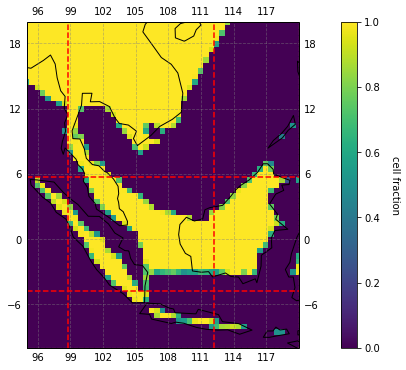

In [128]:
fig, ax = plot_z(redIA5_cell_fraction, lat_360_720, lon_360_720, 'cell fraction', coastlines=True, output=True)

ax.set_xlim(95,120)
ax.set_ylim(-10,20)

s_ind = 170
n_ind = 191
w_ind = 557
e_ind = 584
ax.axhline(lat_360_720[s_ind], ls='--', c='red')
ax.axhline(lat_360_720[n_ind], ls='--', c='red')
ax.axvline(lon_360_720[w_ind], ls='--', c='red')
ax.axvline(lon_360_720[e_ind], ls='--', c='red')

plt.show()

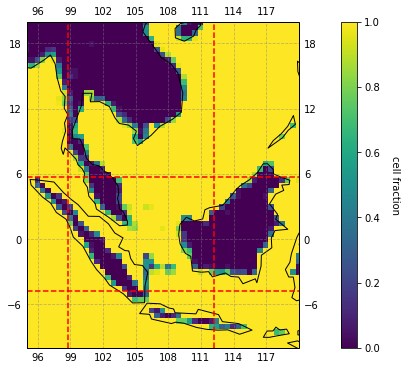

In [129]:
fig, ax = plot_z(lith_mask_redIA5[:,:,0], lat_360_720, lon_360_720, 'cell fraction', coastlines=True, output=True)

ax.set_xlim(95,120)
ax.set_ylim(-10,20)

ax.axhline(lat_360_720[s_ind], ls='--', c='red')
ax.axhline(lat_360_720[n_ind], ls='--', c='red')
ax.axvline(lon_360_720[w_ind], ls='--', c='red')
ax.axvline(lon_360_720[e_ind], ls='--', c='red')

plt.show()

In [130]:
for i in range(s_ind, n_ind):
    for j in range(w_ind, e_ind):
        if redIA5_cell_fraction[i,j]!=0 and lith_mask_redIAsunda5[i,j,0]==1:
            lith_mask_redIAsunda5[i,j,0] = 1 - redIA5_cell_fraction[i,j]
            lith_mask_redIAsunda5[i,j,2] = 0.5 - (lith_mask_redIAsunda5[i,j,0]/2)
            lith_mask_redIAsunda5[i,j,6] = 0.5 - (lith_mask_redIAsunda5[i,j,0]/2)
        elif redIA5_cell_fraction[i,j]!=0:
            lith_mask_redIAsunda5[i,j,2] = lith_mask_redIAsunda5[i,j,2] +\
                                           0.5 * (redIA5_cell_fraction[i,j] - (1-lith_mask_redIAsunda5[i,j,0]))
            lith_mask_redIAsunda5[i,j,6] = lith_mask_redIAsunda5[i,j,6] +\
                                           0.5 * (redIA5_cell_fraction[i,j] - (1-lith_mask_redIAsunda5[i,j,0]))
            lith_mask_redIAsunda5[i,j,0] = 1 - redIA5_cell_fraction[i,j]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  


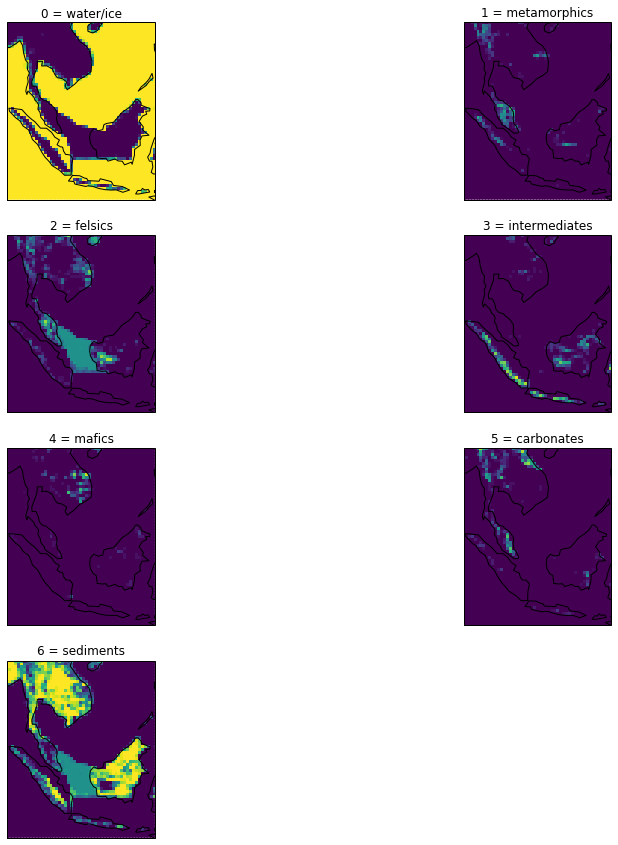

In [131]:
fig = plt.figure(figsize=(15,15))

for i in range(7):
    ax = plt.subplot(4,2,i+1, projection=ccrs.PlateCarree())
    
    z = lith_mask_redIAsunda5[:,:,i]
    im = ax.pcolormesh(lon_360_720, lat_360_720, z, transform=ccrs.PlateCarree())
    
    ax.coastlines()
    ax.set_title(lith_class[i])
    ax.set_xlim(95,120)
    ax.set_ylim(-10,20)
    
fig.tight_layout()
plt.show(fig)

In [132]:
# initialize netCDF
lith_mask_nc = Dataset('../Output/lith_mask_redIAsunda5.nc', 'w', format='NETCDF4')
lith_mask_nc.description = 'lithologic mask: 360x720 resolution, reduced IA with Sunda Shelf at 5 Ma.'

# create dimensions
lith_mask_nc.createDimension('lon', dim_360_720[1])
lith_mask_nc.createDimension('lat', dim_360_720[0])
lith_mask_nc.createDimension('lith', 7)

# initialize variables
lon_var = lith_mask_nc.createVariable('lon', 'f', ('lon',))
lat_var = lith_mask_nc.createVariable('lat', 'f', ('lat',))
lith_var = lith_mask_nc.createVariable('lith', 'i', ('lith',))
frac_var = lith_mask_nc.createVariable('frac', 'f', ('lith','lat','lon',), fill_value=1e36)

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
lith_var.long_name = 'lithology'
frac_var.long_name = 'lithology area fraction'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
lith_var.units = 'lithology'
frac_var.units = 'fraction'

lon_var.axis = 'X'
lat_var.axis = 'Y'
lith_var.axis = 'Z'

# fill variables
lon_var[:] = lon_360_720
lat_var[:] = lat_360_720
lith_var[:] = np.arange(7, dtype=np.int8)
frac_var[:,:,:] = np.transpose(lith_mask_redIAsunda5.copy(), (2,0,1))
    
lith_mask_nc.close()

#### land area

In [133]:
land_area_redIAsunda5 = land_area_redIA5.copy()

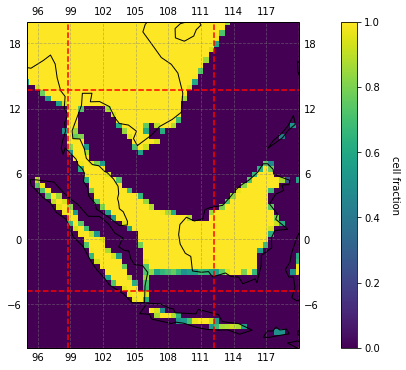

In [134]:
fig, ax = plot_z(redIA5_cell_fraction, lat_360_720, lon_360_720, 'cell fraction', coastlines=True, output=True)

ax.set_xlim(95,120)
ax.set_ylim(-10,20)

s_ind = 170
n_ind = 207
w_ind = 557
e_ind = 584
ax.axhline(lat_360_720[s_ind], ls='--', c='red')
ax.axhline(lat_360_720[n_ind], ls='--', c='red')
ax.axvline(lon_360_720[w_ind], ls='--', c='red')
ax.axvline(lon_360_720[e_ind], ls='--', c='red')

plt.show()

In [135]:
for i in range(s_ind, n_ind):
    for j in range(w_ind, e_ind):
        land_area_redIAsunda5[i,j] = cell_area_360_720[i,j] * redIA5_cell_fraction[i,j]

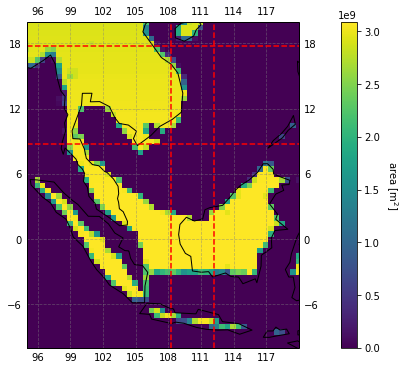

In [136]:
fig, ax = plot_z(land_area_redIAsunda5, lat_360_720, lon_360_720, 'area [m$^{2}$]', coastlines=True, output=True)

ax.set_xlim(95,120)
ax.set_ylim(-10,20)

s_ind = 197
n_ind = 215
w_ind = 576
e_ind = 584
ax.axhline(lat_360_720[s_ind], ls='--', c='red')
ax.axhline(lat_360_720[n_ind], ls='--', c='red')
ax.axvline(lon_360_720[w_ind], ls='--', c='red')
ax.axvline(lon_360_720[e_ind], ls='--', c='red')

plt.show()

In [137]:
# initialize netCDF
land_area_nc = Dataset('../Output/land_area_redIAsunda5.nc', 'w', format='NETCDF4')
land_area_nc.description = 'Area of land in each 0.5x0.5 cell: 360x720 resolution, reduced IA with Sunda Shelf at 5 Ma.'

# create dimensions
land_area_nc.createDimension('lon', dim_360_720[1])
land_area_nc.createDimension('lat', dim_360_720[0])

# initialize variables
lon_var = land_area_nc.createVariable('lon', 'f', ('lon',))
lat_var = land_area_nc.createVariable('lat', 'f', ('lat',))
area_var = land_area_nc.createVariable('area', 'f', ('lat','lon',))

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
area_var.long_name = 'area'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
area_var.units = 'm^2'

lon_var.axis = 'X'
lat_var.axis = 'Y'

# fill variables
lon_var[:] = lon_360_720
lat_var[:] = lat_360_720
area_var[:,:] = land_area_redIAsunda5
    
land_area_nc.close()

#### slope

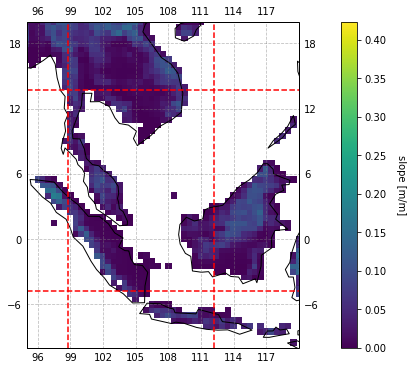

In [138]:
fig, ax = plot_z(raw_slope, lat_360_720, lon_360_720, 'slope [m/m]',
                 coastlines=True, output=True)

ax.set_xlim(95,120)
ax.set_ylim(-10,20)

s_ind = 170
n_ind = 207
w_ind = 557
e_ind = 584
ax.axhline(lat_360_720[s_ind], ls='--', c='red')
ax.axhline(lat_360_720[n_ind], ls='--', c='red')
ax.axvline(lon_360_720[w_ind], ls='--', c='red')
ax.axvline(lon_360_720[e_ind], ls='--', c='red')

plt.show()

In [139]:
slope_redIAsunda5 = raw_slope.copy()

for i in range(s_ind, n_ind):
    for j in range(w_ind, e_ind):
        if np.isnan(raw_slope[i,j]) and land_area_redIAsunda5[i,j]!=0:
            slope_redIAsunda5[i,j] = flat_area_mean_slope

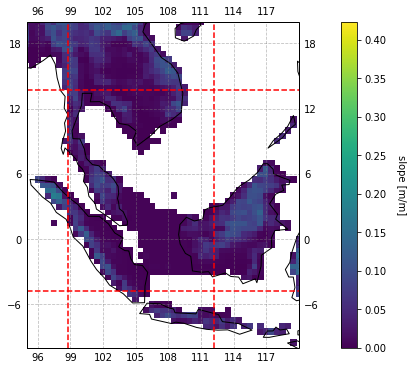

In [140]:
fig, ax = plot_z(slope_redIAsunda5, lat_360_720, lon_360_720, 'slope [m/m]',
                 coastlines=True, output=True)

ax.set_xlim(95,120)
ax.set_ylim(-10,20)

s_ind = 170
n_ind = 207
w_ind = 557
e_ind = 584
ax.axhline(lat_360_720[s_ind], ls='--', c='red')
ax.axhline(lat_360_720[n_ind], ls='--', c='red')
ax.axvline(lon_360_720[w_ind], ls='--', c='red')
ax.axvline(lon_360_720[e_ind], ls='--', c='red')

plt.show()

In [141]:
# initialize netCDF
slope_nc = Dataset('../Output/slope_redIAsunda5.nc', 'w', format='NETCDF4')
slope_nc.description = 'Slope in each 0.5x0.5 cell: 360x720 resolution, reduced IA with Sunda Shelf at 5 Ma.'

# create dimensions
slope_nc.createDimension('lon', dim_360_720[1])
slope_nc.createDimension('lat', dim_360_720[0])

# initialize variables
lon_var = slope_nc.createVariable('lon', 'f', ('lon',))
lat_var = slope_nc.createVariable('lat', 'f', ('lat',))
slope_var = slope_nc.createVariable('slope', 'f', ('lat','lon',), fill_value=1e36)

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
slope_var.long_name = 'slope'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
slope_var.units = 'm/m'

lon_var.axis = 'X'
lat_var.axis = 'Y'

# fill variables
lon_var[:] = lon_360_720
lat_var[:] = lat_360_720

slope_redIAsunda5_masked = slope_redIAsunda5.copy()
slope_redIAsunda5_masked[np.isnan(slope_redIAsunda5)] = 1e36
slope_var[:,:] = slope_redIAsunda5_masked
    
slope_nc.close()

#### runoff

Latitude spacing is 4 inds.

Longitude spacing is 5 inds.

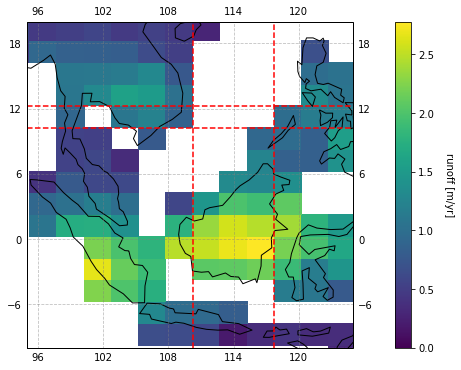

In [142]:
fig, ax = plot_z(raw_runoff[0,:,:], lat_360_720, lon_360_720, 'runoff [m/yr]',
                 coastlines=True, output=True)

ax.set_xlim(95,125)
ax.set_ylim(-10,20)

s_ind = 200
n_ind = 204
w_ind = 580
e_ind = 595
ax.axhline(lat_360_720[s_ind], ls='--', c='red')
ax.axhline(lat_360_720[n_ind], ls='--', c='red')
ax.axvline(lon_360_720[w_ind], ls='--', c='red')
ax.axvline(lon_360_720[e_ind], ls='--', c='red')

plt.show()

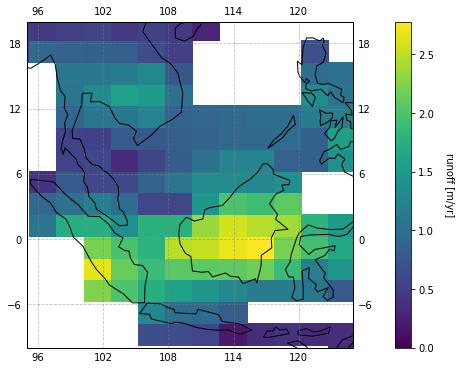

In [143]:
runoff_redIAsunda5 = runoff_redIAsunda.copy()

fig, ax = plot_z(runoff_redIAsunda5[0,:,:], lat_360_720, lon_360_720, 'runoff [m/yr]',
                 coastlines=True, output=True)

ax.set_xlim(95,125)
ax.set_ylim(-10,20)

plt.show()

In [144]:
# initialize netCDF
runoff_nc = Dataset('../Output/runoff_redIAsunda5.nc', 'w', format='NETCDF4')
runoff_nc.description = 'GFDL runoff data interpolated to higher resolution, with zonally interpolated Sunda Shelf at 5 Ma.'

# create dimensions
runoff_nc.createDimension('lon', dim_360_720[1])
runoff_nc.createDimension('lat', dim_360_720[0])
runoff_nc.createDimension('lvl', 3)

# initialize variables
lon_var = runoff_nc.createVariable('lon', 'f', ('lon',))
lat_var = runoff_nc.createVariable('lat', 'f', ('lat',))
lvl_var = runoff_nc.createVariable('lvl', 'f', ('lvl',))
rnf_var = runoff_nc.createVariable('rnf', 'f', ('lvl','lat','lon',), fill_value=1e36)

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
lvl_var.long_name = 'CO2'
rnf_var.long_name = 'runoff'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
lvl_var.units = 'ppm'
rnf_var.units = 'm/yr'

lon_var.axis = 'X'
lat_var.axis = 'Y'
lvl_var.axis = 'Z'

# fill variables
lon_var[:] = lon_360_720
lat_var[:] = lat_360_720

CO2s = np.array([286,572,1144])
lvl_var[:] = CO2s

runoff_redIAsunda5_masked = runoff_redIAsunda5.copy()
runoff_redIAsunda5_masked[np.isnan(runoff_redIAsunda5_masked)] = 1e36
rnf_var[0,:,:] = runoff_redIAsunda5_masked[0,:,:]
rnf_var[1,:,:] = runoff_redIAsunda5_masked[1,:,:]
rnf_var[2,:,:] = runoff_redIAsunda5_masked[2,:,:]
    
runoff_nc.close()

## Traps

### noDeccan = no Deccan

#### lithology

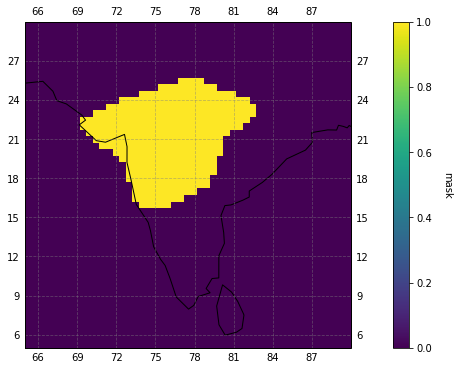

In [145]:
Deccan_mask_nc = Dataset(drive_path + 'Land_Masks/Deccan_mask.nc')
Deccan_mask = Deccan_mask_nc.variables['Band1'][:,:].data
Deccan_mask[np.isnan(Deccan_mask)] = 0
Deccan_mask[Deccan_mask > 1e30] = 0

fig, ax = plot_z(Deccan_mask, lat_360_720, lon_360_720, 'mask', coastlines=True, output=True)

ax.set_xlim(65,90)
ax.set_ylim(5,30)

plt.show()

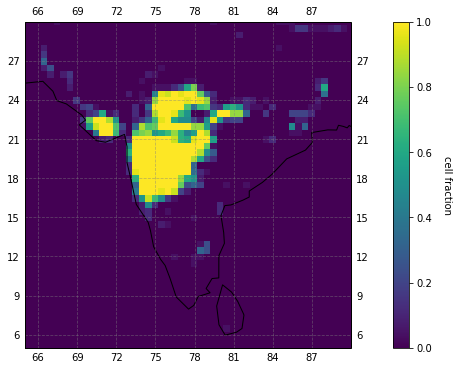

In [146]:
lith_mask_noDeccan = lith_mask_360_720.copy()

fig, ax = plot_z(lith_mask_noDeccan[:,:,4], lat_360_720, lon_360_720, 'cell fraction', coastlines=True, output=True)

ax.set_xlim(65,90)
ax.set_ylim(5,30)

plt.show()

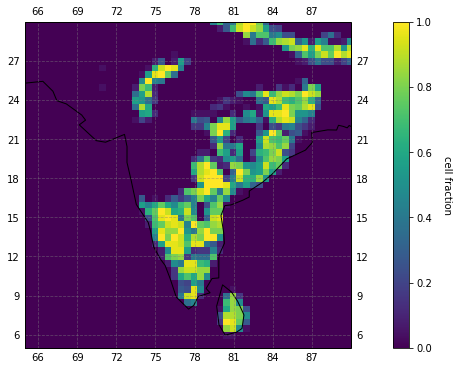

In [147]:
fig, ax = plot_z(lith_mask_noDeccan[:,:,1], lat_360_720, lon_360_720, 'cell fraction', coastlines=True, output=True)

ax.set_xlim(65,90)
ax.set_ylim(5,30)

plt.show()

Convert all mafics to bulk continental crust/metamorphics:

In [148]:
lith_mask_noDeccan[:,:,1][Deccan_mask==1] = lith_mask_noDeccan[:,:,1][Deccan_mask==1] +\
                                            lith_mask_noDeccan[:,:,4][Deccan_mask==1]
lith_mask_noDeccan[:,:,4][Deccan_mask==1] = 0

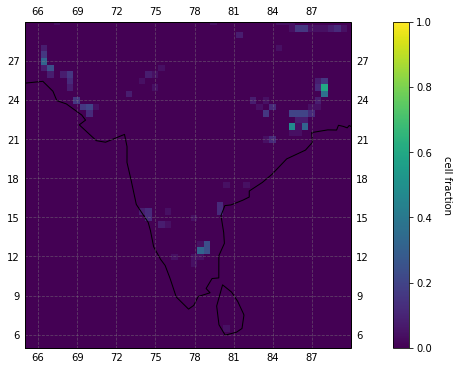

In [149]:
fig, ax = plot_z(lith_mask_noDeccan[:,:,4], lat_360_720, lon_360_720, 'cell fraction', coastlines=True, output=True)

ax.set_xlim(65,90)
ax.set_ylim(5,30)

plt.show()

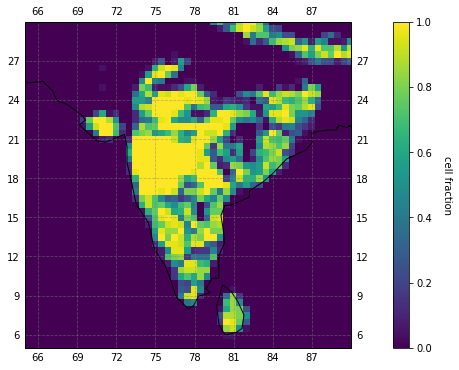

In [150]:
fig, ax = plot_z(lith_mask_noDeccan[:,:,1], lat_360_720, lon_360_720, 'cell fraction', coastlines=True, output=True)

ax.set_xlim(65,90)
ax.set_ylim(5,30)

plt.show()

In [151]:
# initialize netCDF
lith_mask_nc = Dataset('../Output/lith_mask_noDeccan.nc', 'w', format='NETCDF4')
lith_mask_nc.description = 'lithologic mask: 360x720 resolution, no Deccan.'

# create dimensions
lith_mask_nc.createDimension('lon', dim_360_720[1])
lith_mask_nc.createDimension('lat', dim_360_720[0])
lith_mask_nc.createDimension('lith', 7)

# initialize variables
lon_var = lith_mask_nc.createVariable('lon', 'f', ('lon',))
lat_var = lith_mask_nc.createVariable('lat', 'f', ('lat',))
lith_var = lith_mask_nc.createVariable('lith', 'i', ('lith',))
frac_var = lith_mask_nc.createVariable('frac', 'f', ('lith','lat','lon',), fill_value=1e36)

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
lith_var.long_name = 'lithology'
frac_var.long_name = 'lithology area fraction'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
lith_var.units = 'lithology'
frac_var.units = 'fraction'

lon_var.axis = 'X'
lat_var.axis = 'Y'
lith_var.axis = 'Z'

# fill variables
lon_var[:] = lon_360_720
lat_var[:] = lat_360_720
lith_var[:] = np.arange(7, dtype=np.int8)
frac_var[:,:,:] = np.transpose(lith_mask_noDeccan.copy(), (2,0,1))
    
lith_mask_nc.close()

### noET = no Ethiopian Traps

#### lithology

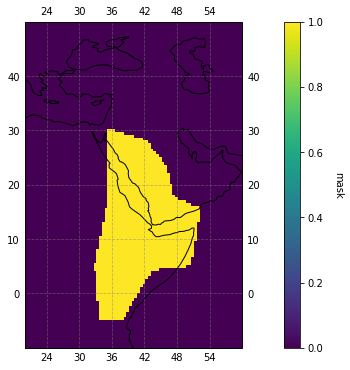

In [152]:
ET_mask_nc = Dataset(drive_path + 'Land_Masks/ET_mask.nc')
ET_mask = ET_mask_nc.variables['Band1'][:,:].data
ET_mask[np.isnan(ET_mask)] = 0
ET_mask[ET_mask > 1e30] = 0

fig, ax = plot_z(ET_mask, lat_360_720, lon_360_720, 'mask', coastlines=True, output=True)

ax.set_xlim(20,60)
ax.set_ylim(-10,50)

plt.show()

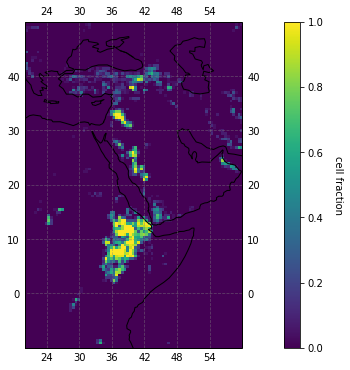

In [153]:
lith_mask_noET = lith_mask_360_720.copy()

fig, ax = plot_z(lith_mask_noET[:,:,4], lat_360_720, lon_360_720, 'cell fraction', coastlines=True, output=True)

ax.set_xlim(20,60)
ax.set_ylim(-10,50)

plt.show()

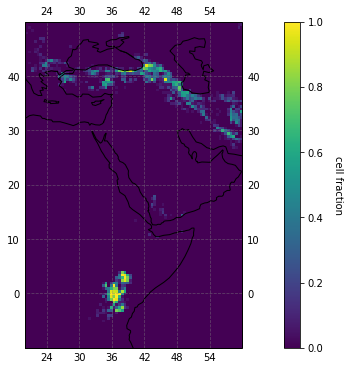

In [154]:
fig, ax = plot_z(lith_mask_noET[:,:,3], lat_360_720, lon_360_720, 'cell fraction', coastlines=True, output=True)

ax.set_xlim(20,60)
ax.set_ylim(-10,50)

plt.show()

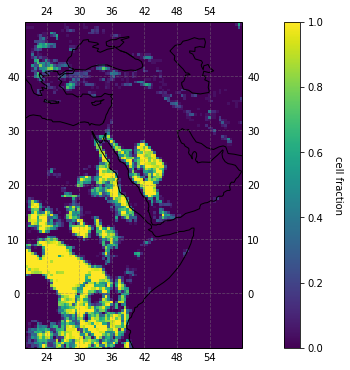

In [155]:
fig, ax = plot_z(lith_mask_noET[:,:,1], lat_360_720, lon_360_720, 'cell fraction', coastlines=True, output=True)

ax.set_xlim(20,60)
ax.set_ylim(-10,50)

plt.show()

Convert all mafics and intermediates to bulk continental crust/metamorphics:

In [156]:
lith_mask_noET[:,:,1][ET_mask==1] = lith_mask_noET[:,:,1][ET_mask==1] +\
                                    lith_mask_noET[:,:,4][ET_mask==1]
lith_mask_noET[:,:,4][ET_mask==1] = 0

lith_mask_noET[:,:,1][ET_mask==1] = lith_mask_noET[:,:,1][ET_mask==1] +\
                                    lith_mask_noET[:,:,3][ET_mask==1]
lith_mask_noET[:,:,3][ET_mask==1] = 0

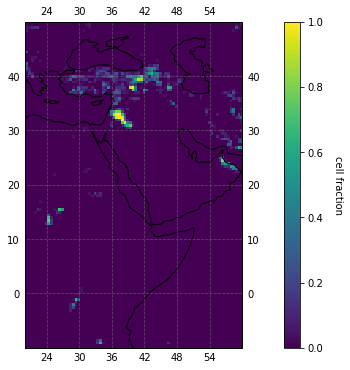

In [157]:
fig, ax = plot_z(lith_mask_noET[:,:,4], lat_360_720, lon_360_720, 'cell fraction', coastlines=True, output=True)

ax.set_xlim(20,60)
ax.set_ylim(-10,50)

plt.show()

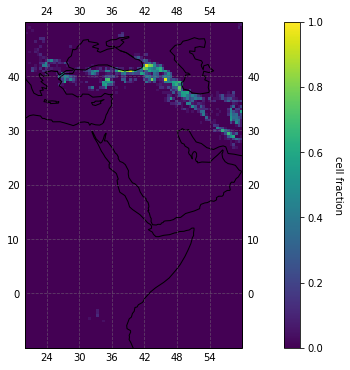

In [158]:
fig, ax = plot_z(lith_mask_noET[:,:,3], lat_360_720, lon_360_720, 'cell fraction', coastlines=True, output=True)

ax.set_xlim(20,60)
ax.set_ylim(-10,50)

plt.show()

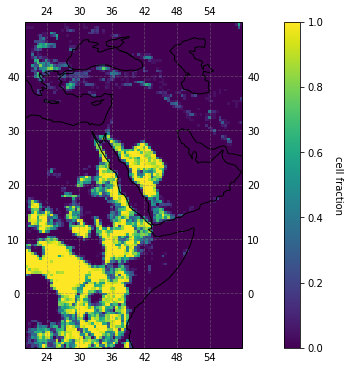

In [159]:
fig, ax = plot_z(lith_mask_noET[:,:,1], lat_360_720, lon_360_720, 'cell fraction', coastlines=True, output=True)

ax.set_xlim(20,60)
ax.set_ylim(-10,50)

plt.show()

In [160]:
# initialize netCDF
lith_mask_nc = Dataset('../Output/lith_mask_noET.nc', 'w', format='NETCDF4')
lith_mask_nc.description = 'lithologic mask: 360x720 resolution, no Ethiopian Traps.'

# create dimensions
lith_mask_nc.createDimension('lon', dim_360_720[1])
lith_mask_nc.createDimension('lat', dim_360_720[0])
lith_mask_nc.createDimension('lith', 7)

# initialize variables
lon_var = lith_mask_nc.createVariable('lon', 'f', ('lon',))
lat_var = lith_mask_nc.createVariable('lat', 'f', ('lat',))
lith_var = lith_mask_nc.createVariable('lith', 'i', ('lith',))
frac_var = lith_mask_nc.createVariable('frac', 'f', ('lith','lat','lon',), fill_value=1e36)

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
lith_var.long_name = 'lithology'
frac_var.long_name = 'lithology area fraction'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
lith_var.units = 'lithology'
frac_var.units = 'fraction'

lon_var.axis = 'X'
lat_var.axis = 'Y'
lith_var.axis = 'Z'

# fill variables
lon_var[:] = lon_360_720
lat_var[:] = lat_360_720
lith_var[:] = np.arange(7, dtype=np.int8)
frac_var[:,:,:] = np.transpose(lith_mask_noET.copy(), (2,0,1))
    
lith_mask_nc.close()

### noTraps = no Deccan and Ethiopian Traps

#### lithology

In [161]:
lith_mask_noTraps = lith_mask_360_720.copy()

In [162]:
lith_mask_noTraps[:,:,1][Deccan_mask==1] = lith_mask_noTraps[:,:,1][Deccan_mask==1] +\
                                           lith_mask_noTraps[:,:,4][Deccan_mask==1]
lith_mask_noTraps[:,:,4][Deccan_mask==1] = 0

In [163]:
lith_mask_noTraps[:,:,1][ET_mask==1] = lith_mask_noTraps[:,:,1][ET_mask==1] +\
                                       lith_mask_noTraps[:,:,4][ET_mask==1]
lith_mask_noTraps[:,:,4][ET_mask==1] = 0

lith_mask_noTraps[:,:,1][ET_mask==1] = lith_mask_noTraps[:,:,1][ET_mask==1] +\
                                       lith_mask_noTraps[:,:,3][ET_mask==1]
lith_mask_noTraps[:,:,3][ET_mask==1] = 0

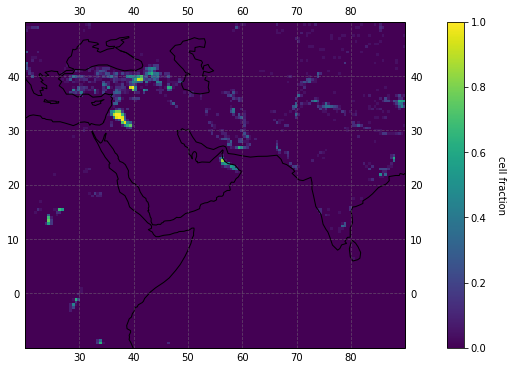

In [164]:
fig, ax = plot_z(lith_mask_noTraps[:,:,4], lat_360_720, lon_360_720, 'cell fraction', coastlines=True, output=True)

ax.set_xlim(20,90)
ax.set_ylim(-10,50)

plt.show()

In [165]:
# initialize netCDF
lith_mask_nc = Dataset('../Output/lith_mask_noTraps.nc', 'w', format='NETCDF4')
lith_mask_nc.description = 'lithologic mask: 360x720 resolution, no Deccan and Ethiopian Traps.'

# create dimensions
lith_mask_nc.createDimension('lon', dim_360_720[1])
lith_mask_nc.createDimension('lat', dim_360_720[0])
lith_mask_nc.createDimension('lith', 7)

# initialize variables
lon_var = lith_mask_nc.createVariable('lon', 'f', ('lon',))
lat_var = lith_mask_nc.createVariable('lat', 'f', ('lat',))
lith_var = lith_mask_nc.createVariable('lith', 'i', ('lith',))
frac_var = lith_mask_nc.createVariable('frac', 'f', ('lith','lat','lon',), fill_value=1e36)

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
lith_var.long_name = 'lithology'
frac_var.long_name = 'lithology area fraction'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
lith_var.units = 'lithology'
frac_var.units = 'fraction'

lon_var.axis = 'X'
lat_var.axis = 'Y'
lith_var.axis = 'Z'

# fill variables
lon_var[:] = lon_360_720
lat_var[:] = lat_360_720
lith_var[:] = np.arange(7, dtype=np.int8)
frac_var[:,:,:] = np.transpose(lith_mask_noTraps.copy(), (2,0,1))
    
lith_mask_nc.close()

## Bulk Continental Crust

Convert all land pixels to be bulk continental crust.

### lithology

In [166]:
lith_mask_allbcc = lith_mask_360_720.copy()

lith_mask_allbcc[:,:,1] = 1 - lith_mask_allbcc[:,:,0]
lith_mask_allbcc[:,:,2] = 0
lith_mask_allbcc[:,:,3] = 0
lith_mask_allbcc[:,:,4] = 0
lith_mask_allbcc[:,:,5] = 0
lith_mask_allbcc[:,:,6] = 0

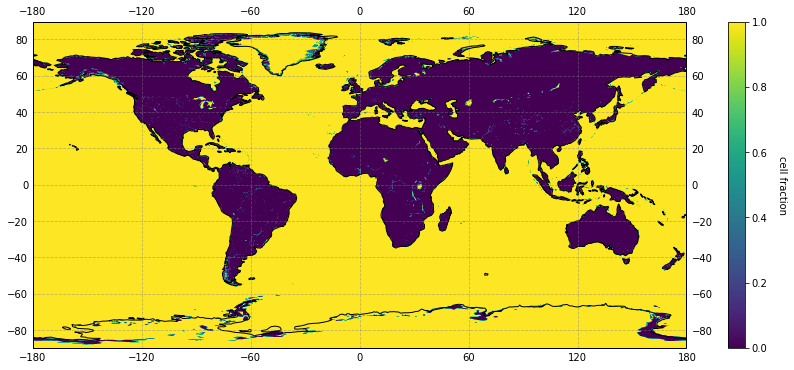

In [167]:
fig, ax = plot_z(lith_mask_allbcc[:,:,0], lat_360_720, lon_360_720, 'cell fraction', coastlines=True, output=True)

plt.show()

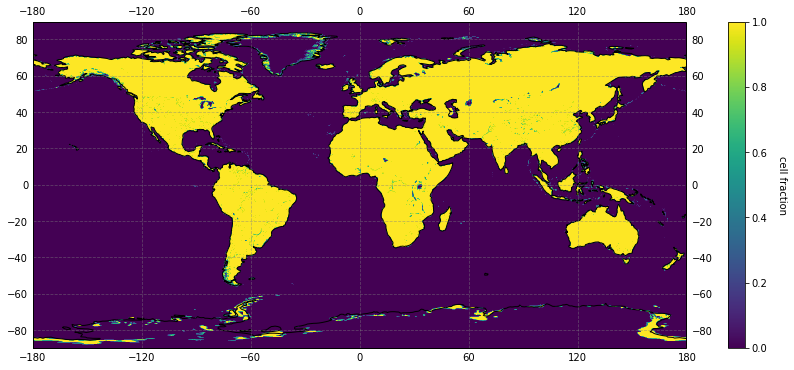

In [168]:
fig, ax = plot_z(lith_mask_allbcc[:,:,1], lat_360_720, lon_360_720, 'cell fraction', coastlines=True, output=True)

plt.show()

In [169]:
# initialize netCDF
lith_mask_nc = Dataset('../Output/lith_mask_allbcc.nc', 'w', format='NETCDF4')
lith_mask_nc.description = 'lithologic mask: 360x720 resolution, all bulk continental crust.'

# create dimensions
lith_mask_nc.createDimension('lon', dim_360_720[1])
lith_mask_nc.createDimension('lat', dim_360_720[0])
lith_mask_nc.createDimension('lith', 7)

# initialize variables
lon_var = lith_mask_nc.createVariable('lon', 'f', ('lon',))
lat_var = lith_mask_nc.createVariable('lat', 'f', ('lat',))
lith_var = lith_mask_nc.createVariable('lith', 'i', ('lith',))
frac_var = lith_mask_nc.createVariable('frac', 'f', ('lith','lat','lon',), fill_value=1e36)

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
lith_var.long_name = 'lithology'
frac_var.long_name = 'lithology area fraction'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
lith_var.units = 'lithology'
frac_var.units = 'fraction'

lon_var.axis = 'X'
lat_var.axis = 'Y'
lith_var.axis = 'Z'

# fill variables
lon_var[:] = lon_360_720
lat_var[:] = lat_360_720
lith_var[:] = np.arange(7, dtype=np.int8)
frac_var[:,:,:] = np.transpose(lith_mask_allbcc.copy(), (2,0,1))
    
lith_mask_nc.close()